# Baseline survey cadence evolution: v3.3 

In [1]:
# import necessary and useful packages
import os
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import rubin_sim.maf as maf

This notebook explores summary metric comparison across different simulations, primarily in the comparison of these metrics across the evolution of the baseline survey strategy. 

Jump to comparison of metrics targeting: 
* [SCOC overview](#SCOC)
* [Science Requirements Document](#SRD)
* [DESC WFD coverage](#DESCWFD)
* [Transient and Variable Stars](#TVS)
* [Solar System Objects](#SSO)
* [Active Galactic Nuclei](#AGN)
* [Galaxies](#Galaxies)
* [Strong Lensing](#StrongLensing)
* [Stars](#Stars)
* [Milky Way and Local Volume](#MWLV)

## Get background information about summary statistics for the v3.3 runs

Read the information about the metric sets in this version of the sims outputs. The metric_sets defines groups of summary statistics that have been identified as likely relevant for comparing simulations for particular science purposes. 

In [2]:
metric_sets = maf.get_metric_sets('metric_sets.json')
msets = list(metric_sets.groupby('metric set').first().index)

If you do not have the summary.h5 file on disk, you can download it from [sims_featureScheduler_runs3.3/maf/summary.h5 at USDF](https://s3df.slac.stanford.edu/data/rubin/sim-data/sims_featureScheduler_runs3.3/maf/summary.h5). 

In [3]:
summaries = maf.get_metric_summaries(summary_source='summary.h5')
print(f"This summary h5 file contains information on {len(summaries.index)} simulations.")

This summary h5 file contains information on 76 simulations.


Identify some subsets of runs that belong in common families, such as runs that were created for deep drilling field exploration or galactic plane coverage exploration. 

In [4]:
# Weather variations on baseline strategy
weather_runs = [r for r in summaries.index if 'weather' in r]
offsets = [int(w.split('dso')[-1].split('v3')[0]) for w in weather_runs]
idx = np.argsort(offsets)
weather_runs = [weather_runs[i] for i in idx]
weather_runs

# DDF variations
ddf = [r for r in summaries.index if 'ddf_' in r]
ddf

# Rolling cadence variations
roll = [r for r in summaries.index if 'roll' in r and 'mw' not in r]
roll

# SMWLV variations
mw = [r for r in summaries.index if 'mw' in r or 'lmc' in r or 'reweight' in r or 'no_high_blob' in r]
mw

# u band variations
uband = [r for r in summaries.index if 'u_exp' in r]
uband

# Baseline sims, and put them in order of evolution
baselines = [r for r in summaries.index if 'baseline' in r]
versions = [float(r.split('_v')[-1].split('_10yrs')[0]) for r in baselines]
idx = np.argsort(versions)
baselines = [baselines[i] for i in idx]
# Rearrange to put retro first in list
tmp = baselines[0]
baselines[0] = baselines[1]
baselines[1] = tmp
# drop m2 baseline
baselines = baselines[:-1]
print(baselines)

baseline_run = 'baseline_v3.3_10yrs'

baseline_dict = {'retro_baseline_v2.0_10yrs': 'v1.x', 
                 'baseline_v2.0_10yrs':'v2.0', 
                 'baseline_v2.1_10yrs':'v2.1',
                 'baseline_v2.2_10yrs':'v2.2',
                 'baseline_v3.0_10yrs':'v3.0',
                 'baseline_v3.2_10yrs':'v3.2',
                'baseline_v3.3_10yrs':'v3.3'}

outdir = 'tmp_fig'
try:
    os.mkdir(outdir)
except:
    pass

['retro_baseline_v2.0_10yrs', 'baseline_v2.0_10yrs', 'baseline_v2.1_10yrs', 'baseline_v2.2_10yrs', 'baseline_v3.0_10yrs', 'baseline_v3.2_10yrs', 'baseline_v3.3_10yrs']


We can derive approximate uncertainties for some of our relevant metrics by looking at their variation across the different 'weather' instances of the baseline strategy.
This isn't necessarily appropriate for all metrics, but it does give a useful indications.

In [5]:
dev = np.std(summaries.loc[weather_runs], axis=0)
hilo = np.abs(summaries.loc[weather_runs].max() - summaries.loc[weather_runs].min())

nvis = [m for m in summaries if "Nvisits" in m and "UniSlicer" in m and 'All' in m]
print(f"example: Total NVisits (in millions) std dev {dev[nvis].iloc[0]/1e6: .2f}, range is {hilo[nvis].iloc[0]/1e6 :.2f}, baseline {summaries.loc[baseline_run, nvis].iloc[0]/1e6 :.2f}")

example: Total NVisits (in millions) std dev  0.04, range is 0.16, baseline 2.13


In [6]:
filter_colors = {"u": "cyan", "g": "g", "r": "orange", "i": "r", "z": "m", "y": "b"}

def plot_metric(summaries, uncertainties, runs, msub, fig=None):
    if fig is None:
        fig, ax = plt.subplots() 
    else:
        ax = fig.gca()
    if isinstance(msub, list):
        for m in msub:
            ax.errorbar(runs, summaries[m], yerr=uncertainties[m],
                        marker='.', label=m.replace("Identity ", ""))
    else:
        for i, m in msub.iterrows():
            if len(m['style']) > 1:
                color = m['style'][0]
                linestyle=m['style'][1]
            else:
                color = None
                linestyle = m['style'][0]
            ax.errorbar(runs, summaries[m['metric']], yerr=uncertainties[m['metric']], 
                        color=color, linestyle=linestyle, marker='.', label=m['short_name'])
    plt.legend(loc=(1.01, 0.35), fontsize='x-large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    return fig, ax

## Major updates in v3.3

The major update in v3.3 was that we went to an as-measured set of throughput curves, so the expected m5 depths changed dramatically. 

The throughput curves moved from Al-Ag-Al for the mirror coatings to triple Ag, which improves throughput in grizy but decreases throughput in u band.

First we verify the depths changed as expected from the throughput curves, by looking at the metrics as-measured from the simulation and comparing these to the changes expected in single image depth moving from v1.7 of the throughput curves, as used in baseline_v3.2, to v1.9 of the throughput curves, as used in baseline_v3.3.

run                                                 retro_baseline_v2.0_10yrs  \
metric                                                                          
Median CoaddM5 WFD u band HealpixSubsetSlicer                       25.751288   
Median CoaddM5 WFD g band HealpixSubsetSlicer                       26.915091   
Median CoaddM5 WFD r band HealpixSubsetSlicer                       26.920819   
Median CoaddM5 WFD i band HealpixSubsetSlicer                       26.368703   
Median CoaddM5 WFD z band HealpixSubsetSlicer                       25.669005   
Median CoaddM5 WFD y band HealpixSubsetSlicer                       24.878127   
Mean Median fiveSigmaDepth WFD u band HealpixSu...                  23.534694   
Mean Median fiveSigmaDepth WFD g band HealpixSu...                  24.505321   
Mean Median fiveSigmaDepth WFD r band HealpixSu...                  24.042804   
Mean Median fiveSigmaDepth WFD i band HealpixSu...                  23.466032   
Mean Median fiveSigmaDepth WFD z band HealpixSu...                  22.826973   
Mean Median fiveSigmaDepth WFD y band HealpixSu...                  22.027954   
Median NVisits WFD u band HealpixSubsetSlicer                       55.000000   
Median NVisits WFD g band HealpixSubsetSlicer                       78.000000   
Median NVisits WFD r band HealpixSubsetSlicer                      186.000000   
Median NVisits WFD i band HealpixSubsetSlicer                      186.000000   
Median NVisits WFD z band HealpixSubsetSlicer                      167.000000   
Median NVisits WFD y band HealpixSubsetSlicer                      176.000000   

run                                                 baseline_v2.0_10yrs  \
metric                                                                    
Median CoaddM5 WFD u band HealpixSubsetSlicer                 25.887810   
Median CoaddM5 WFD g band HealpixSubsetSlicer                 26.807612   
Median CoaddM5 WFD r band HealpixSubsetSlicer                 26.822979   
Median CoaddM5 WFD i band HealpixSubsetSlicer                 26.283309   
Median CoaddM5 WFD z band HealpixSubsetSlicer                 25.577299   
Median CoaddM5 WFD y band HealpixSubsetSlicer                 24.816147   
Mean Median fiveSigmaDepth WFD u band HealpixSu...            23.631220   
Mean Median fiveSigmaDepth WFD g band HealpixSu...            24.416554   
Mean Median fiveSigmaDepth WFD r band HealpixSu...            23.938259   
Mean Median fiveSigmaDepth WFD i band HealpixSu...            23.351496   
Mean Median fiveSigmaDepth WFD z band HealpixSu...            22.710287   
Mean Median fiveSigmaDepth WFD y band HealpixSu...            21.962246   
Median NVisits WFD u band HealpixSubsetSlicer                 56.000000   
Median NVisits WFD g band HealpixSubsetSlicer                 74.000000   
Median NVisits WFD r band HealpixSubsetSlicer                184.000000   
Median NVisits WFD i band HealpixSubsetSlicer                187.000000   
Median NVisits WFD z band HealpixSubsetSlicer                166.000000   
Median NVisits WFD y band HealpixSubsetSlicer                171.000000   

run                                                 baseline_v2.1_10yrs  \
metric                                                                    
Median CoaddM5 WFD u band HealpixSubsetSlicer                 25.814827   
Median CoaddM5 WFD g band HealpixSubsetSlicer                 26.826198   
Median CoaddM5 WFD r band HealpixSubsetSlicer                 26.864026   
Median CoaddM5 WFD i band HealpixSubsetSlicer                 26.324190   
Median CoaddM5 WFD z band HealpixSubsetSlicer                 25.559854   
Median CoaddM5 WFD y band HealpixSubsetSlicer                 24.774771   
Mean Median fiveSigmaDepth WFD u band HealpixSu...            23.563482   
Mean Median fiveSigmaDepth WFD g band HealpixSu...            24.425260   
Mean Median fiveSigmaDepth WFD r band HealpixSu...            23.969102   
Mean Median fiveSigmaDepth WFD i band HealpixSu...   

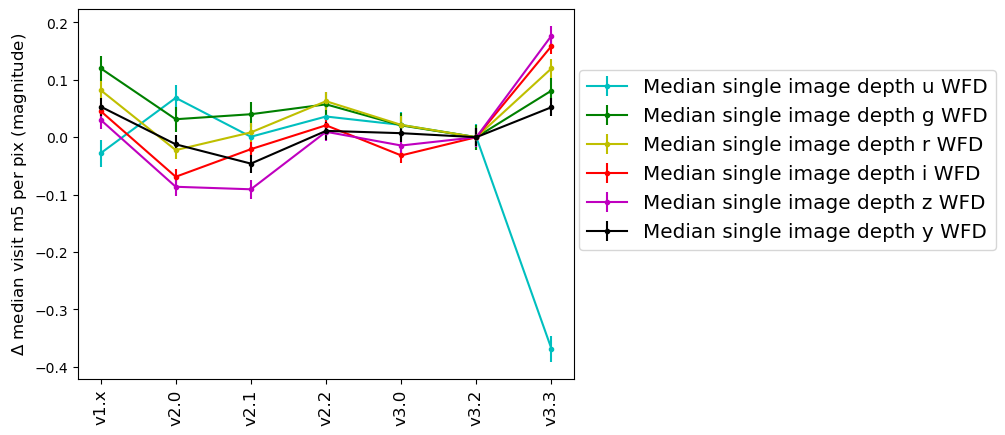

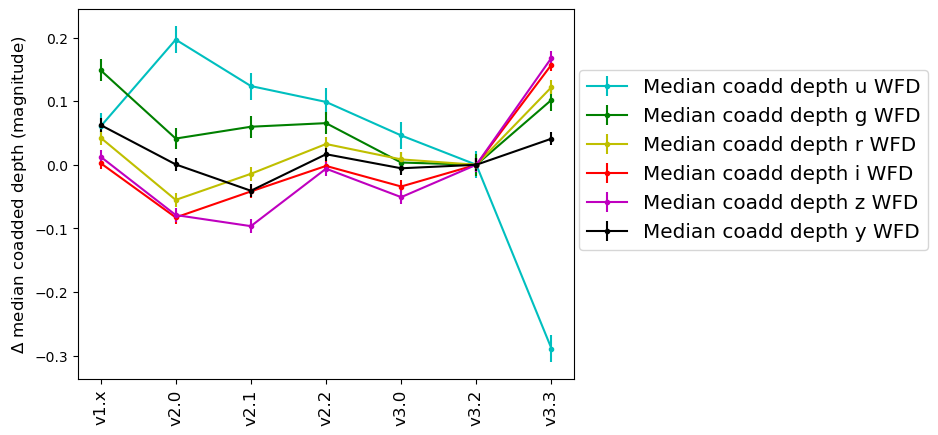

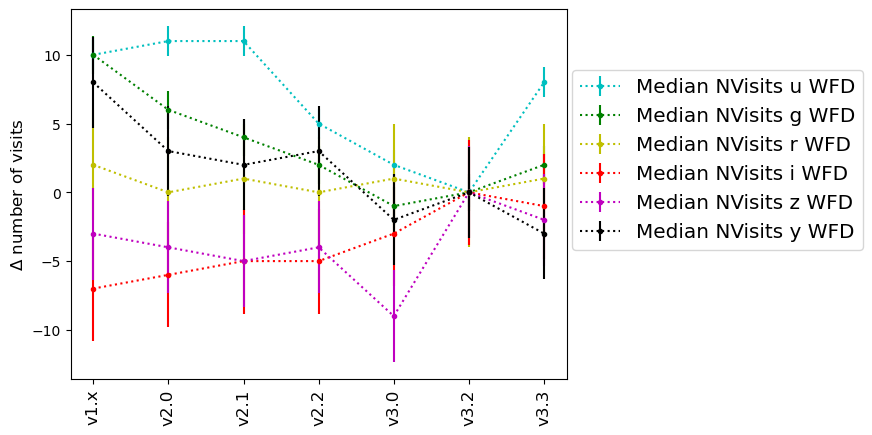

In [52]:
k = 'WFD Depths'
baseline = 'baseline_v3.2_10yrs'

msub = metric_sets.loc[k].query('metric.str.contains("Mean Median")')
fig, ax = plot_metric(summaries.loc[baselines] - summaries.loc[baseline], dev, list(baseline_dict.values()), msub)
ax.set_ylabel("$\Delta$ median visit m5 per pix (magnitude)", fontsize='large')
fig.savefig(os.path.join(outdir, 'visit_m5_per_pix' + '.png'), format='png')


msub = metric_sets.loc[k].query('metric.str.contains("Coadd")')
fig, ax = plot_metric(summaries.loc[baselines] - summaries.loc[baseline], dev, list(baseline_dict.values()), msub)
ax.set_ylabel("$\Delta$ median coadded depth (magnitude)", fontsize='large')
fig.savefig(os.path.join(outdir, 'coadd_m5_per_pix' + '.png'), format='png')

msub = metric_sets.loc[k].query('metric.str.contains("NVisits")')
fig, ax = plot_metric(summaries.loc[baselines] - summaries.loc[baseline], dev, list(baseline_dict.values()), msub)
ax.set_ylabel("$\Delta$ number of visits", fontsize='large')
fig.savefig(os.path.join(outdir, 'nvisit_per_pix'+ '.png'), format='png')

#print(dev[metric_sets.loc[k]['metric']])
summaries.loc[baselines, metric_sets.loc[k]['metric']].T #- summaries.loc[baseline, metric_sets.loc[k]['metric']]

And just check in on the single visit image depth directly, in each band. Note this is slightly different than the "Mean Median 5sigma depth per image" shown above; this is across all visits, not the median at particular point on the sky. 

run                            v3.2   v3.3
metric                                    
Mean m5 WFD u band per image  23.52  23.15
Mean m5 WFD g band per image  24.29  24.37
Mean m5 WFD r band per image  23.85  23.97
Mean m5 WFD i band per image  23.30  23.46
Mean m5 WFD z band per image  22.69  22.87
Mean m5 WFD y band per image  21.93  21.97

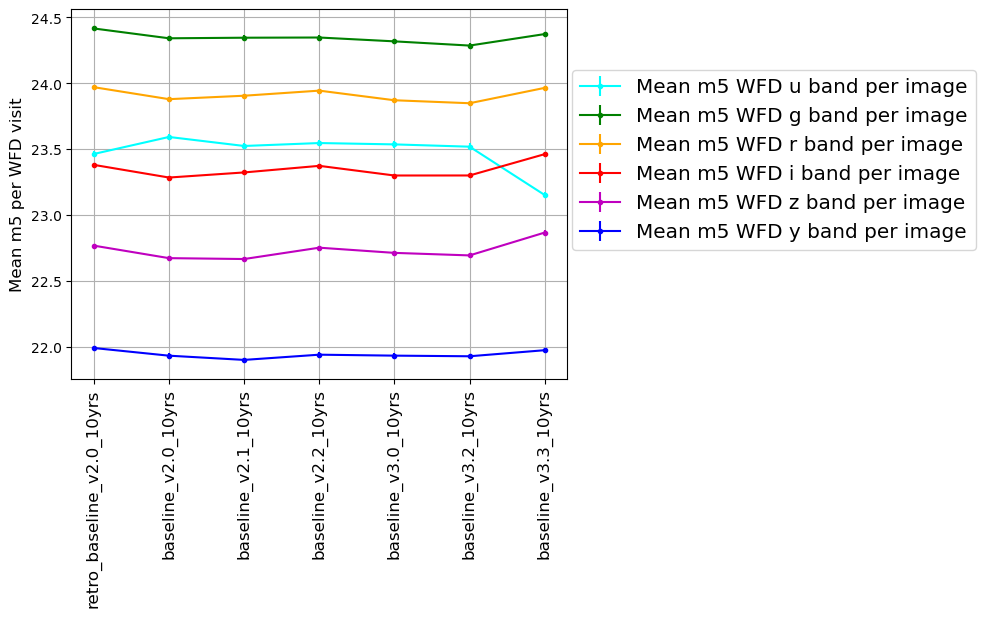

In [8]:
cols = [m for m in summaries if "fiveSigmaDepth" in m and 'band' in m and "UniSlicer" in m
             and ("Mean" in m) and "WFD" in m and "Yr 1" not in m and 'all' not in m]
cols = [f'Identity Mean fiveSigmaDepth WFD {f} band UniSlicer' for f in 'ugrizy']
newcols = [f'Mean m5 WFD {f} band per image' for f in 'ugrizy']

mset = maf.create_metric_set_df('VisitDepths', metrics=cols, short_name=newcols, invert=False, mag=True) 

fig, ax = plt.subplots() 
for f, col, newcol in zip(['u', 'g', 'r', 'i', 'z', 'y'], cols, newcols):
    ax.errorbar(baselines, summaries.loc[baselines, col].values, yerr=dev[col], 
                color=filter_colors[f], marker='.', linestyle='-', label=newcol)
ax.set_ylabel(f"Mean m5 per WFD visit", fontsize='large')
plt.legend(loc=(1.01, 0.35), fontsize='x-large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
ax.grid()
fig.savefig(os.path.join(outdir, 'm5_per_visit'+ '.png'), format='png')

d = (summaries.loc[baselines, cols])[-2:] #- summaries.loc[baseline, cols])[-2:]
d = d.rename(columns=mset.loc['VisitDepths']['short_name']).rename(index={'baseline_v3.2_10yrs': 'v3.2', 'baseline_v3.3_10yrs': 'v3.3'}).round(2)
d.T

We can confirm that these changes are consistent with moving from 1.7 (which is what v3.2 and earlier simulations used) to 1.9 (current, triple Ag) throughput curves. See more in calculations of the [expected single image visit depth changes](https://github.com/lsst-pst/syseng_throughputs/blob/main/notebooks/m5_changes.ipynb). 

We can also check in on the resulting improvement in survey effective time. We expect it to improve because more visits are acquired in redder bands than in u band, so the efficiency gains in grizy can overcome the loss of depth in u.  The "Teff" metric calculates effective survey time, by comparing the actual exposure time and depth against an optimal exposure time and depth. 

In [9]:
cols = [m for m in summaries if "Teff All sky all bands" in m and "UniSlicer" in m and "Normalized" not in m]
cols

d = summaries.loc[baselines, cols]/summaries.loc[baseline, cols]
d = d.rename(columns={'Identity Total Teff All sky all bands UniSlicer': "Teff Total"})
d.round(2)[-2:]

metric               Teff Total
run                            
baseline_v3.2_10yrs        1.00
baseline_v3.3_10yrs        1.21

And finally, let's have a look at those depths compared to SRD design and minimum goals, to evaluate how these changes are redistributing depth (or, in a sense, time) among bandpasses.

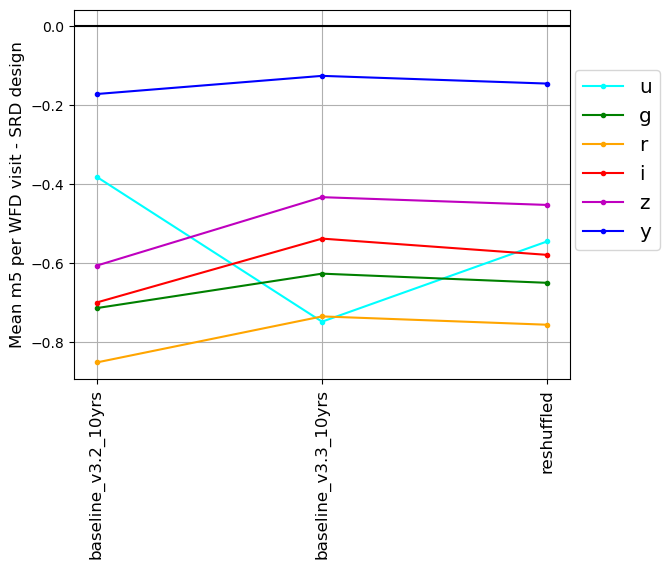

In [10]:
m5_SRD_design = {'u': 23.90, 'g': 25.00, 'r': 24.70, 'i': 24.00, 'z': 23.30, 'y': 22.10}
m5_SRD_minimum = {'u': 23.40, 'g':24.60, 'r': 24.30, 'i': 23.60, 'z': 22.90, 'y': 21.70}

# If we changed exp times to 
# exptime={'u': 38, 'g': 14.5, 'r': 14.5, 'i': 14, 'z': 14.5, 'y': 14.5}, 
# nexp={'u': 1, 'g': 2, 'r': 2, 'i': 2, 'z': 2, 'y': 2},
reshuffle_times = {'u': 0.2035323585733657,
 'g': -0.023238665950835014,
 'r': -0.021109327292084146,
 'i': -0.041219852717425454,
 'z': -0.01969001927820102,
 'y': -0.019553407671317302}

cols = [m for m in summaries if "fiveSigmaDepth" in m and 'band' in m and "UniSlicer" in m
             and ("Mean" in m) and "WFD" in m and "Yr 1" not in m and 'all' not in m]
cols = [f'Identity Mean fiveSigmaDepth WFD {f} band UniSlicer' for f in 'ugrizy']
newcols = [f'Mean m5 WFD {f} band per image' for f in 'ugrizy']

mset = maf.create_metric_set_df('VisitDepths', metrics=cols, short_name=newcols, invert=False, mag=True) 

fig, ax = plt.subplots() 

x = ['baseline_v3.2_10yrs', 'baseline_v3.3_10yrs', 'reshuffled']
for f, col in zip(['u', 'g', 'r', 'i', 'z', 'y'], cols):
    y = np.concatenate([summaries.loc[baselines, col].values[-2:], 
                    [summaries.loc['baseline_v3.3_10yrs', col] + reshuffle_times[f]]])
    ax.plot(x, y - m5_SRD_design[f], 
                color=filter_colors[f], marker='.', linestyle='-', label=f)
    #ax.axhline(m5_SRD_design[f], color=filter_colors[f], linestyle=':', linewidth=3)

ax.axhline(0, color='k', linestyle='-')
ax.set_ylabel(f"Mean m5 per WFD visit - SRD design", fontsize='large')
plt.legend(loc=(1.01, 0.35), fontsize='x-large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
ax.grid()
fig.savefig(os.path.join(outdir, 'm5_per_visit'+ '.png'), format='png')

## Evaluate metrics

Let's evaluate some metric results across these baseline surveys, starting with a very high level overview. 

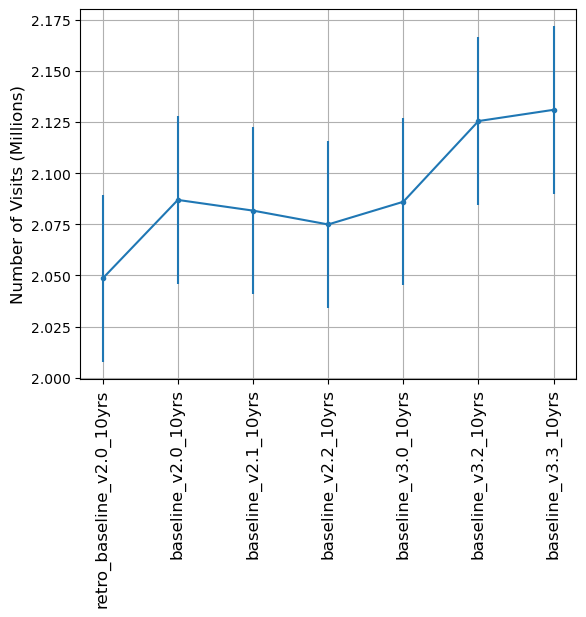

In [11]:
# How did the overall number of visits change for each simulation baseline?  Note some simulations include more shorter visits, and this will be reflected in these numbers.

cols = [m for m in summaries if "Nvisits" in m and "UniSlicer" in m and 'All' in m]
cols

fig, ax = plt.subplots() 
for col in cols:
    ax.errorbar(baselines, summaries.loc[baselines, col].values/1e6, yerr=dev[col]/1e6, 
                marker='.', linestyle='-', label="Number of Visits")
ax.set_ylabel(f"Number of Visits (Millions)", fontsize='large')
#plt.legend(loc=(1.01, 0.35), fontsize='x-large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
ax.grid()
fig.savefig(os.path.join(outdir, 'total_nvisits'+ '.png'), format='png')

### SCOC subsets
<a id='SCOC'></a>
A high level overview in a mesh grid, to compare many metrics quickly but without details. 

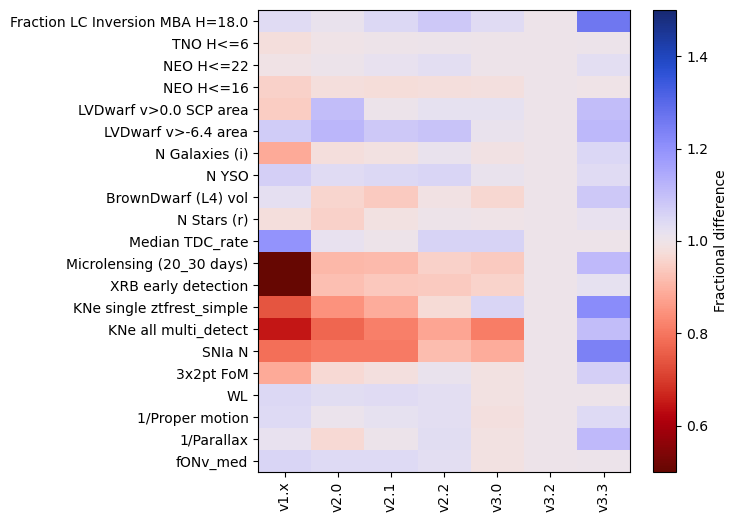

In [12]:
# What about the SCOC high-level overview? 

msub = metric_sets.loc['SCOC']
fig, ax = maf.plot_run_metric_mesh(summaries.loc[baselines, msub['metric']], 
                     baseline_run=baseline,
                     metric_set=msub,
                        metric_label_map=msub['short_name'],
                        run_label_map=baseline_dict)
fig.savefig(os.path.join(outdir, 'scoc_grid'+ '.png'), format='png')

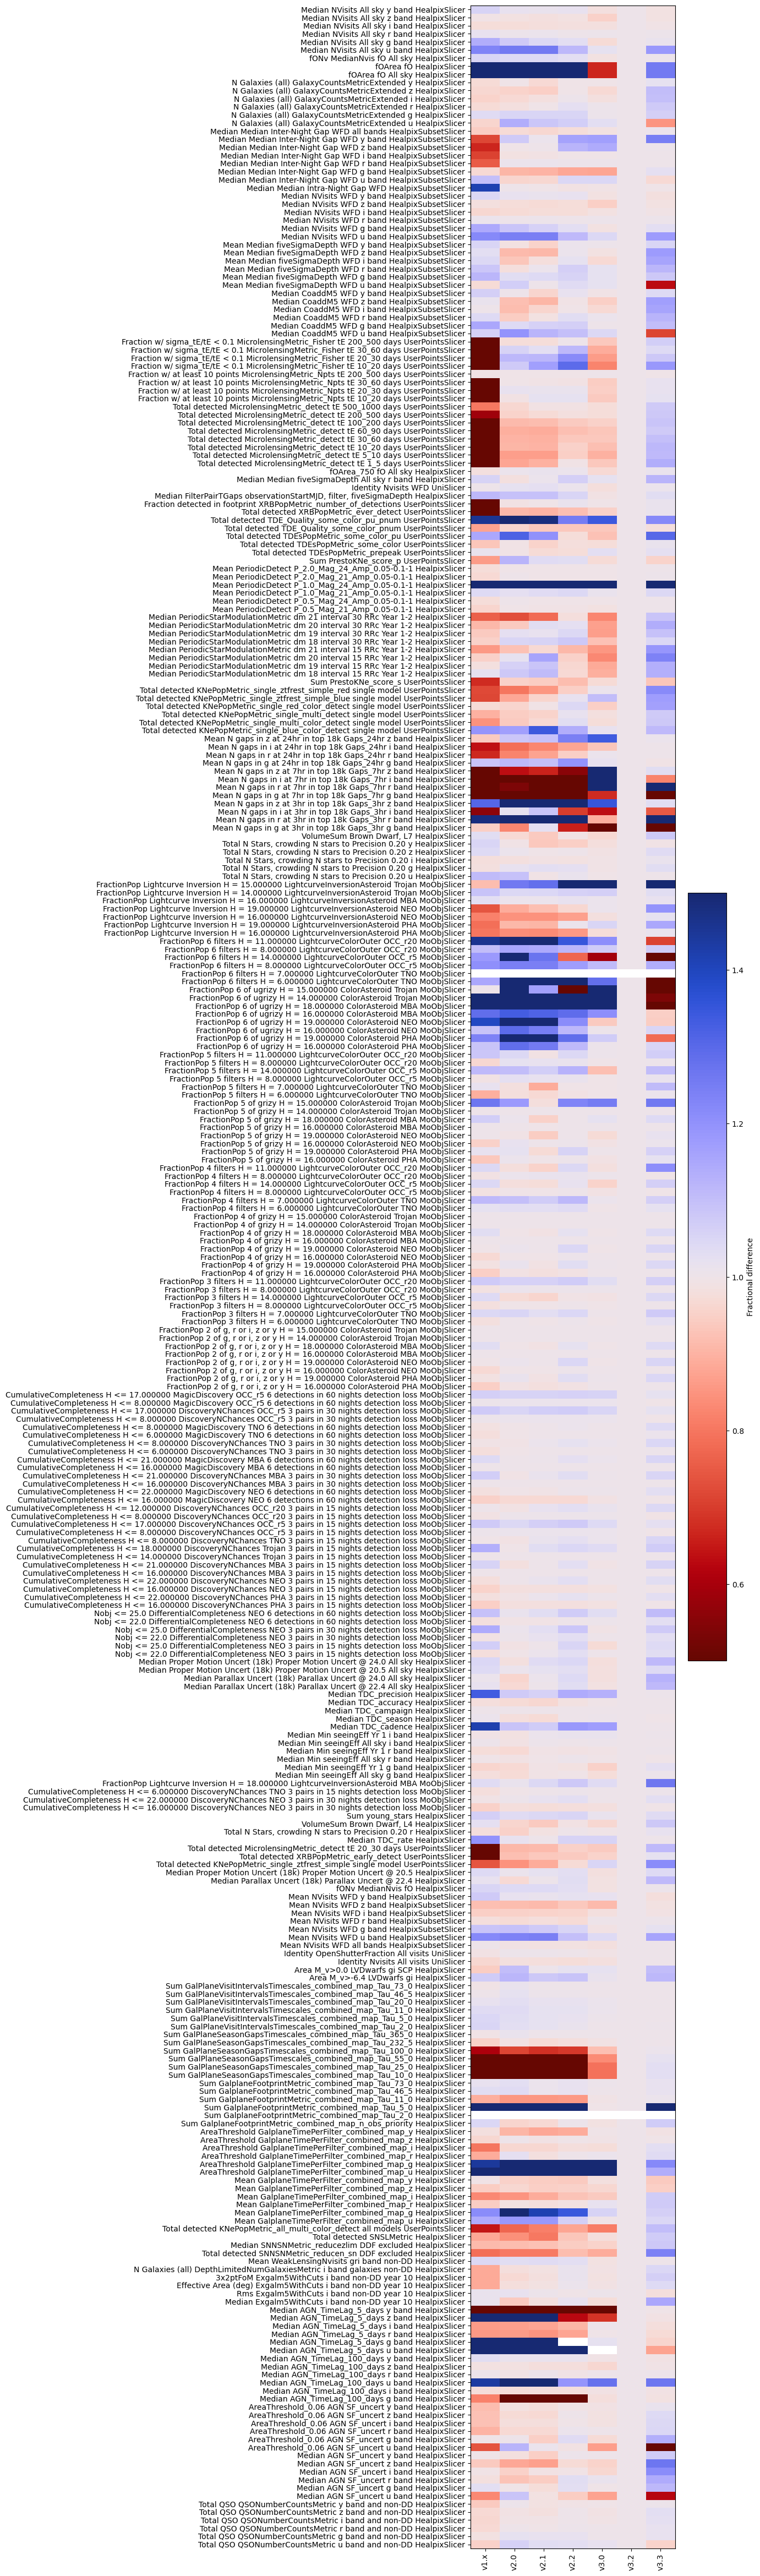

In [13]:
# Plot all the metrics, resulting in a very big and messy plot. Look at overall trends, or for things to investigate further.
non_dd = [m for m in msets if 'DD' not in m]
msub = metric_sets.loc[non_dd].reset_index(drop=True).drop('style', axis=1).drop('short_name', axis=1)
msub = msub.drop_duplicates().set_index('metric', drop=False, verify_integrity=True)

fig, ax = maf.plot_run_metric_mesh(summaries.loc[baselines, msub['metric']], 
                     baseline_run=baseline,
                     metric_set=msub,
                        #metric_label_map=msub['short_name'],
                        run_label_map=baseline_dict)
#fig.set_figwidth(24)
fig.set_figheight(60)
fig.savefig(os.path.join(outdir, 'all_grid'+ '.png'), format='png')

Now we look at the metrics results for subsets of metrics, looking in more depth (which allows us to include error bars which come from the standard deviation of the metric results in the weather runs.

### Science Requirements Document
<a id="SRD"></a>
Metrics coming from the Science Requirements Document, the [SRD](ls.st/srd). 

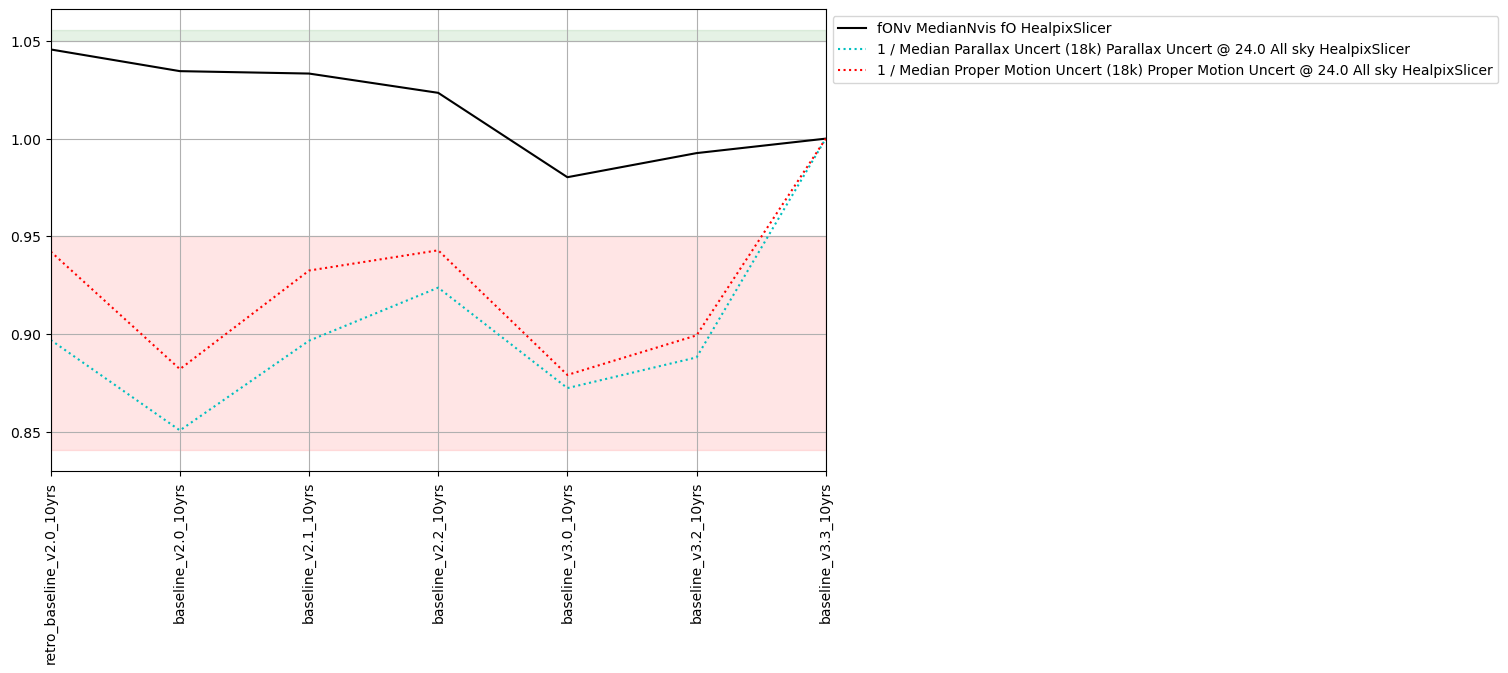

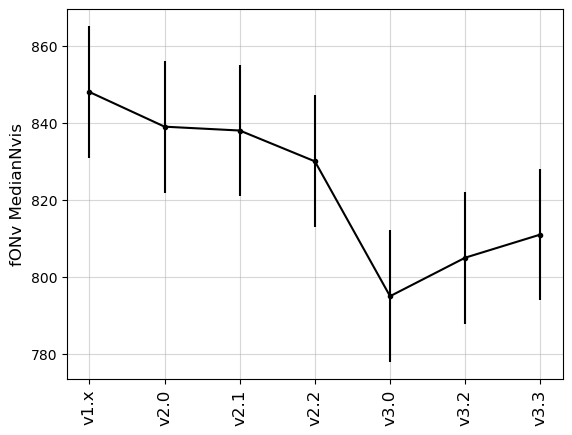

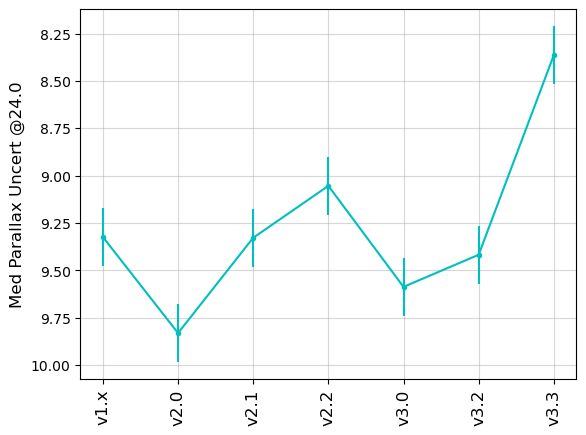

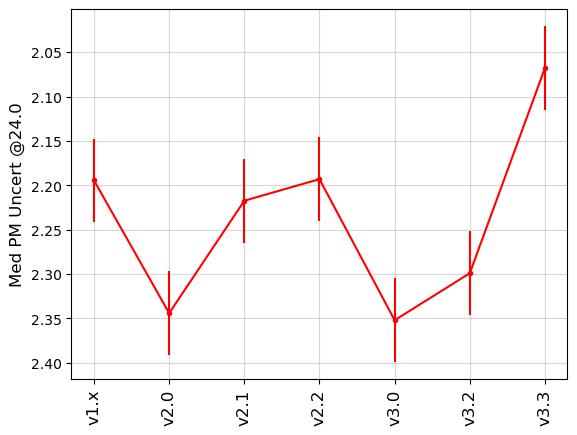

In [14]:
msub = metric_sets.loc['SRD'][::2]  # drop the PM and Parallax at bright mags

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    if m['invert']:
        ax.invert_yaxis()
    ax.grid(True, alpha=0.5)
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

### DESC WFD
<a id="DESC WFD"></a>
Metrics related to DESC WFD goals. These include both static science and transient science.

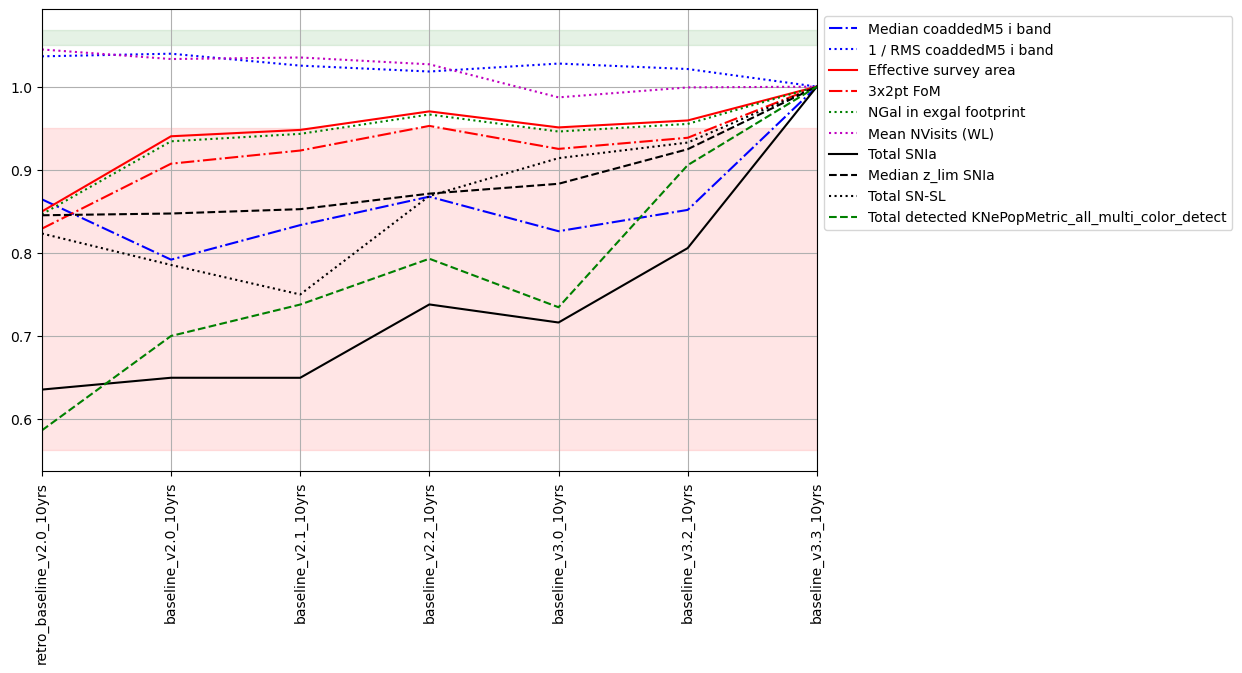

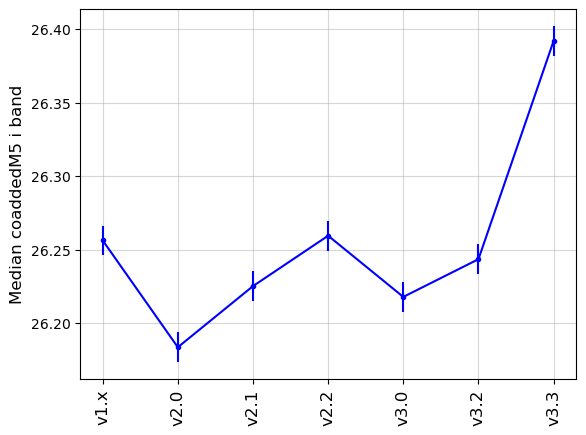

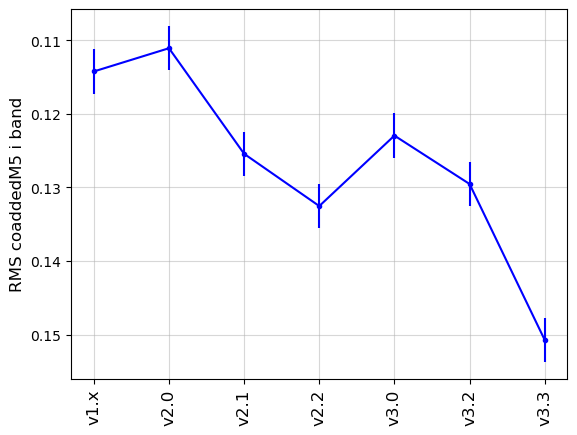

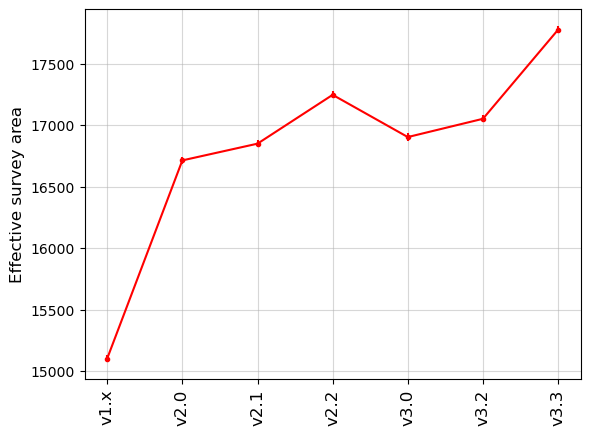

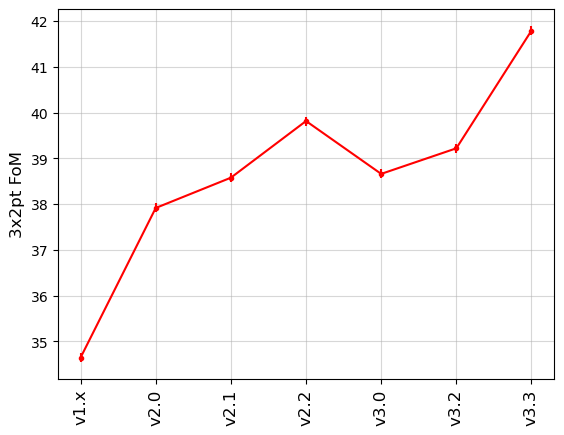

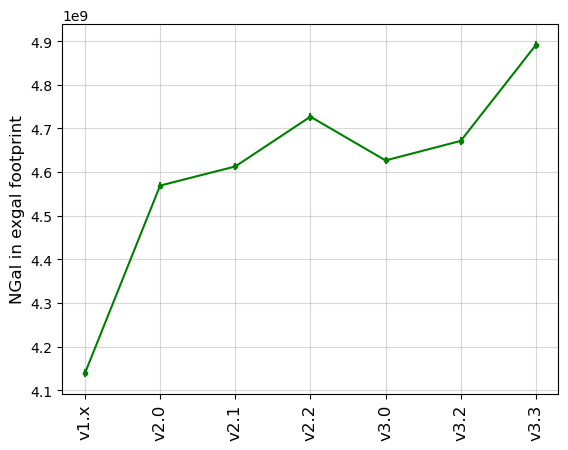

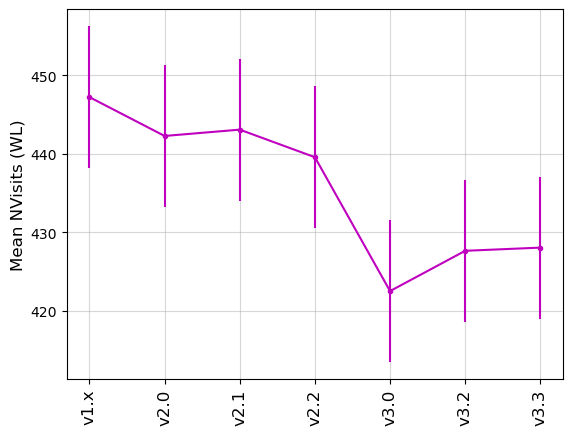

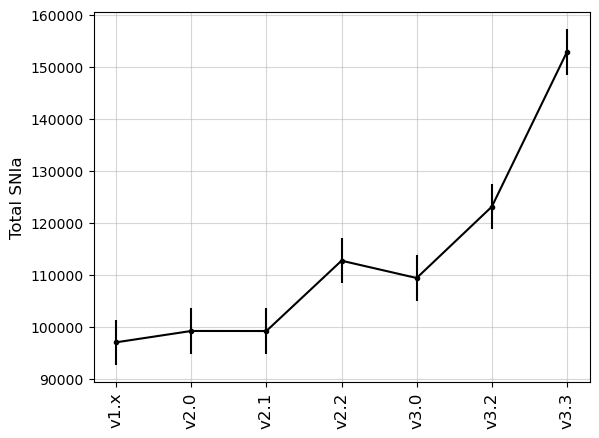

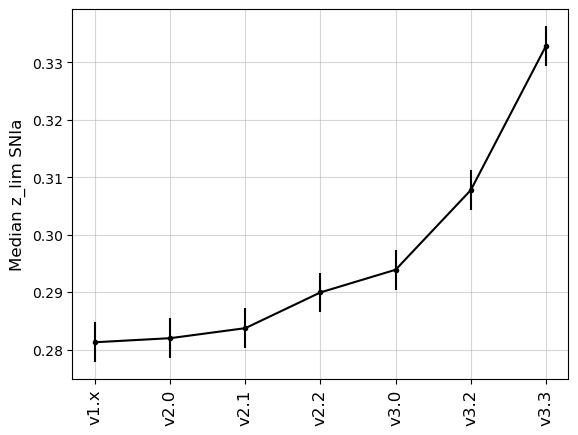

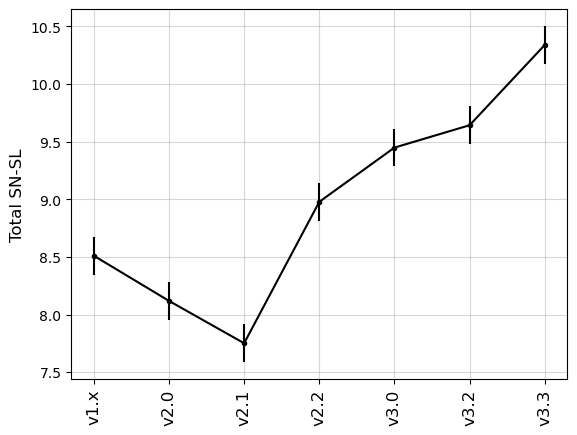

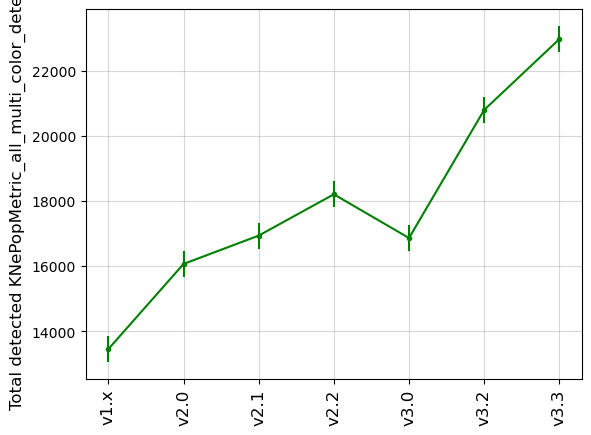

In [15]:
msub = metric_sets.loc['DESC WFD']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    if m['invert']:
        ax.invert_yaxis()
    ax.grid(True, alpha=0.5)
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

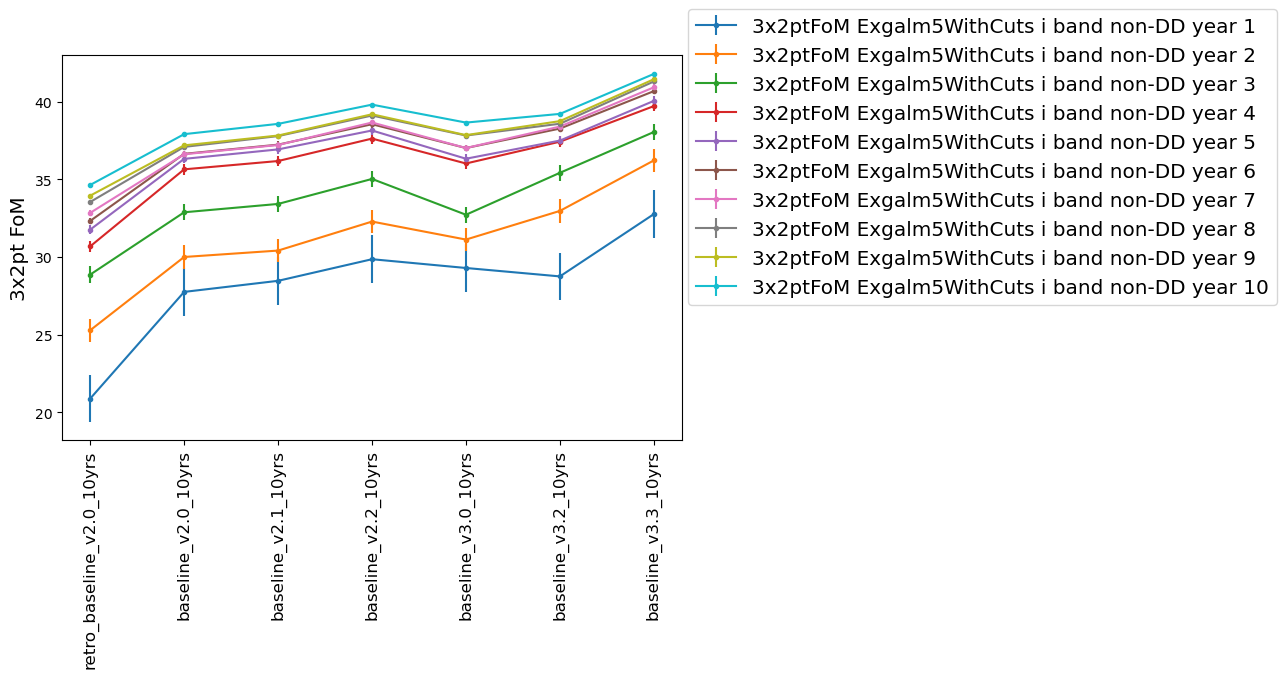

In [16]:
# Compare 3x2pt FOM metrics at individual years, between different simulations.
m1 = []
for yr in range(1, 11):
    m1 += [f'3x2ptFoM Exgalm5WithCuts i band non-DD year {yr} HealpixSlicer']

msub = maf.create_metric_set_df('3x2pt', 
                                metrics=m1, 
                                short_name=[m.replace(' HealpixSlicer', '') for m in m1],
                                style='-',
                               )

fig, ax = plot_metric(summaries.loc[baselines], dev, baselines, msub=msub.loc['3x2pt'])
ax.set_ylabel("3x2pt FoM", fontsize='x-large')
fig.set_figwidth(8)
fig.set_figheight(5)


### Transient and Variable Stars
<a id="TVS"></a>
Metrics related to Transient and Variable Stars collaboration goals. 

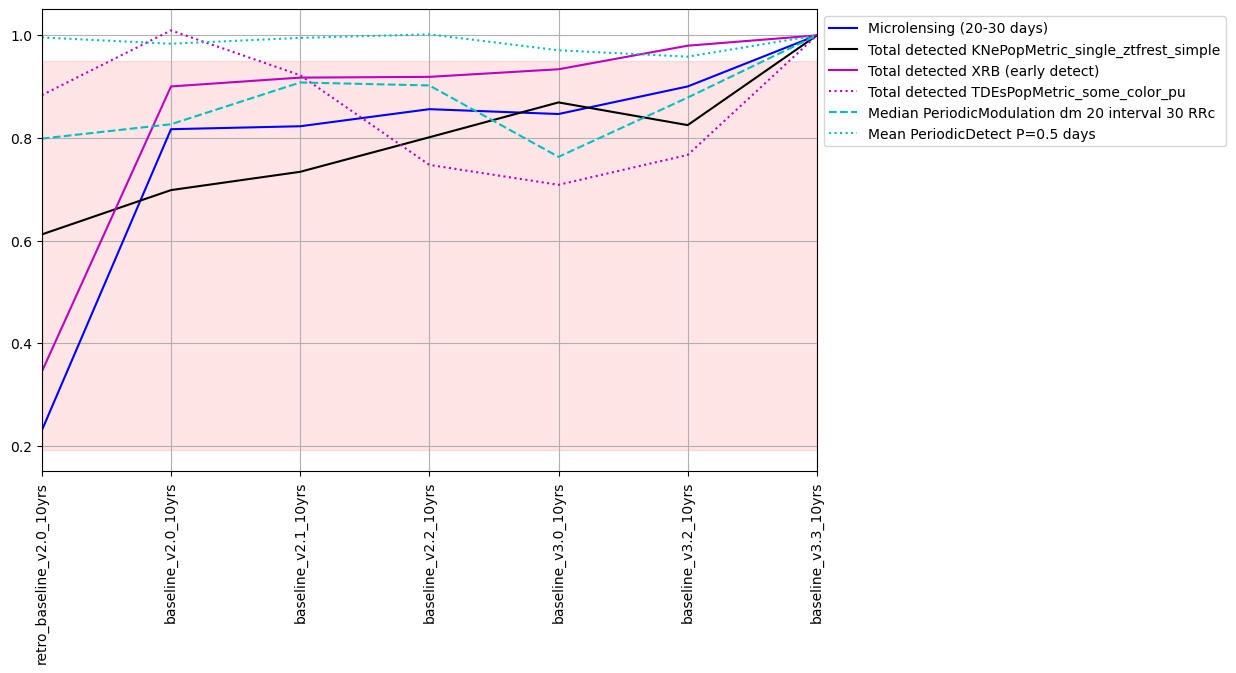

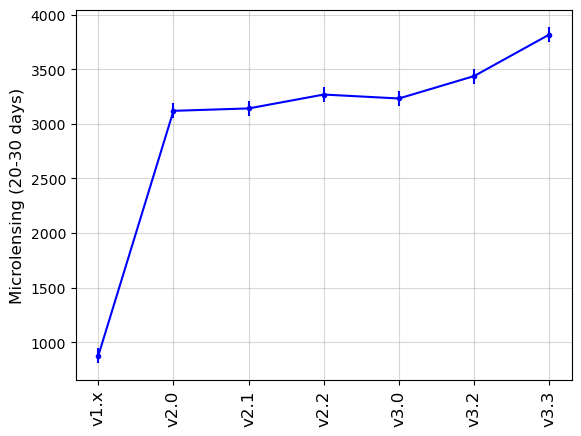

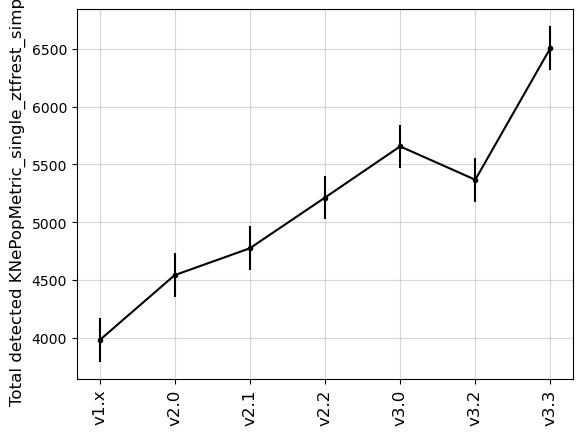

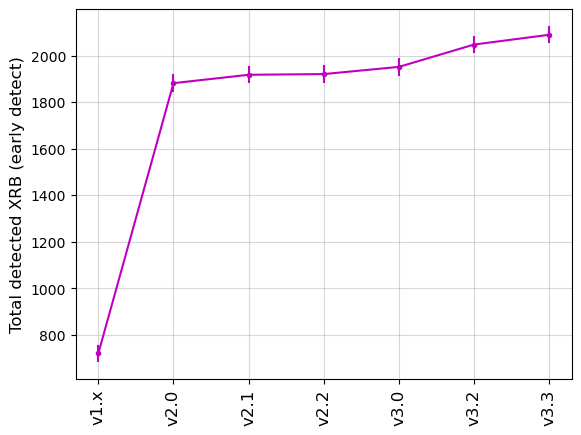

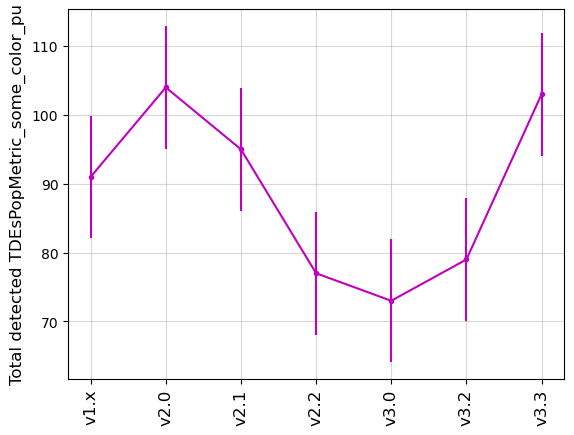

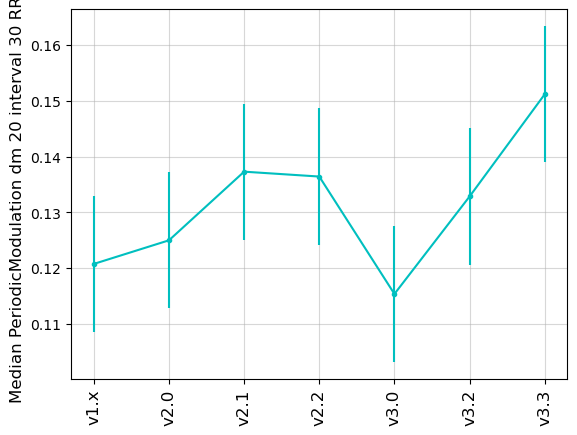

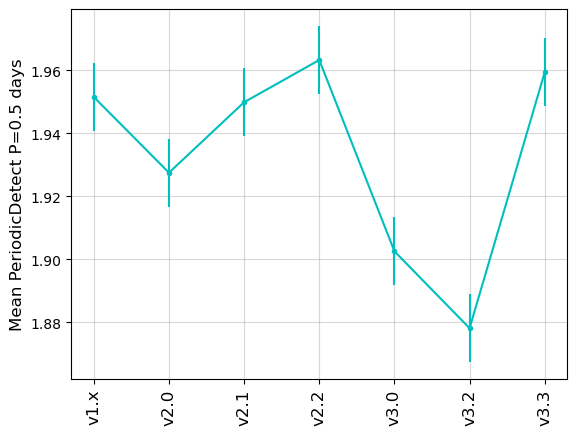

In [17]:
msub = metric_sets.loc['TVS short']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    if m['invert']:
        ax.invert_yaxis()
    ax.grid(True, alpha=0.5)
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

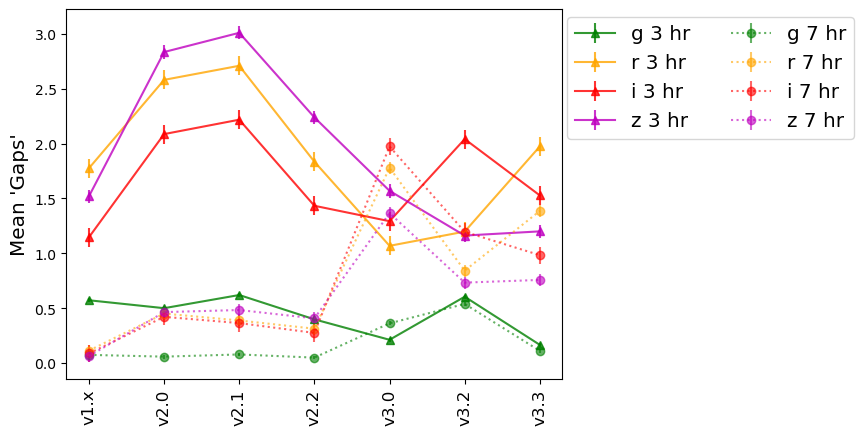

In [18]:
# Time Gaps metric 

fig, ax = plt.subplots()
mset = metric_sets.loc['TVS Gaps'][0:-4]


markers = ['o', 's', '*', '<', '^', 'v', '*', '>', '.', 'X']
j = 0
for i, mm in mset.iterrows():
    m = mm['metric']
    ff = mm['short_name'].split('in ')[-1].split(' at')[0]
    #marker= markers[j]
    marker = 'o'
    if '3' in m:
        marker = '^'
        linestyle='-'
        alpha=0.8
        label=f"{ff} 3 hr"
    if '7' in m:
        marker = 'o'
        linestyle=':'
        alpha=0.6
        label =f"{ff} 7 hr"
    j += 1
    ax.errorbar(baseline_dict.values(), summaries.loc[baselines, m], yerr=dev[m], 
                color=filter_colors[ff], alpha=alpha, marker=marker, linestyle=linestyle, label=label)
plt.legend(loc=(1.01, 0.65), fontsize='x-large', ncols=2)
ax.set_ylabel("Mean 'Gaps'", fontsize='x-large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
fig.savefig(os.path.join(outdir, 'tgaps' + '.png'), format='png')

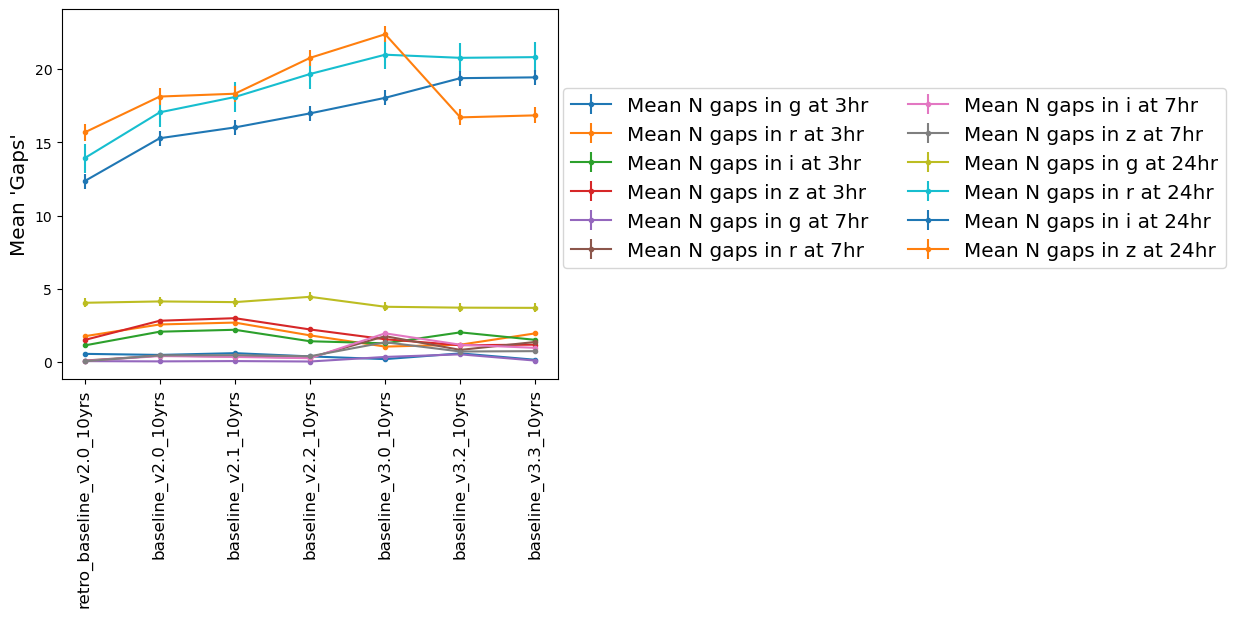

In [19]:
mset = metric_sets.loc['TVS Gaps']

fig, ax = plot_metric(summaries.loc[baselines], dev, baselines, msub=mset)
plt.legend(loc=(1.01, 0.3), fontsize='x-large', ncols=2)
ax.set_ylabel("Mean 'Gaps'", fontsize='x-large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')

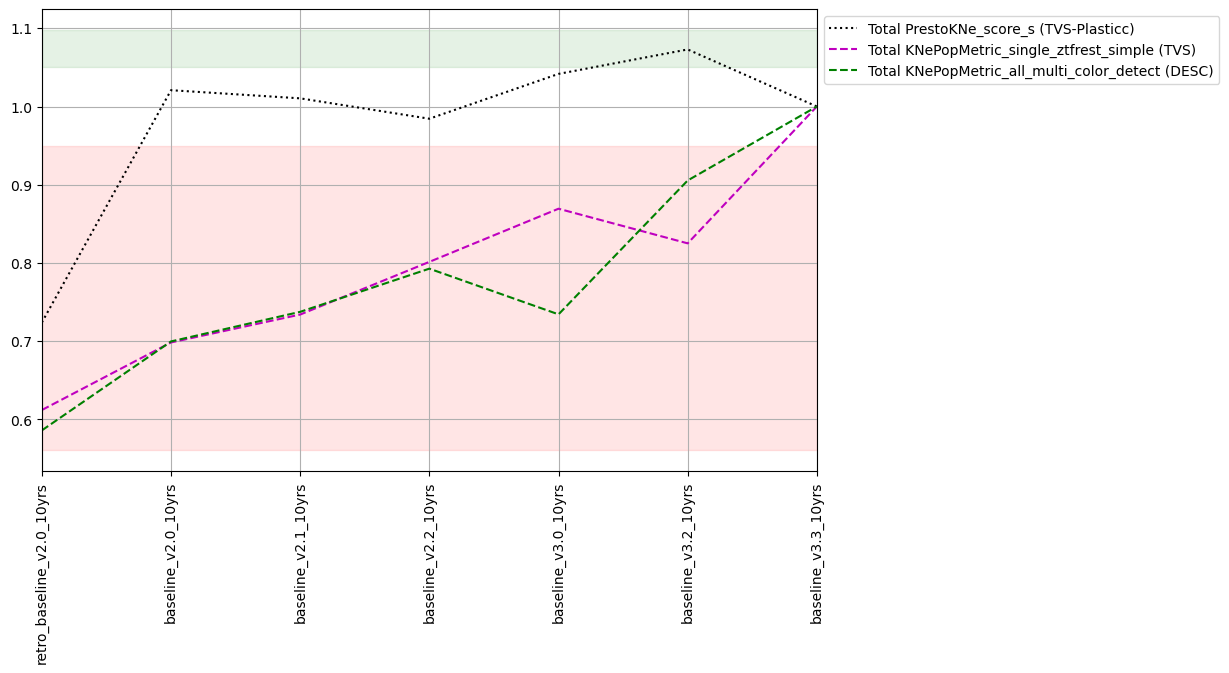

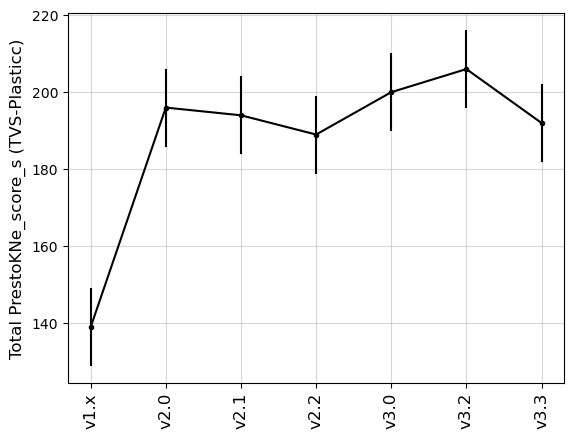

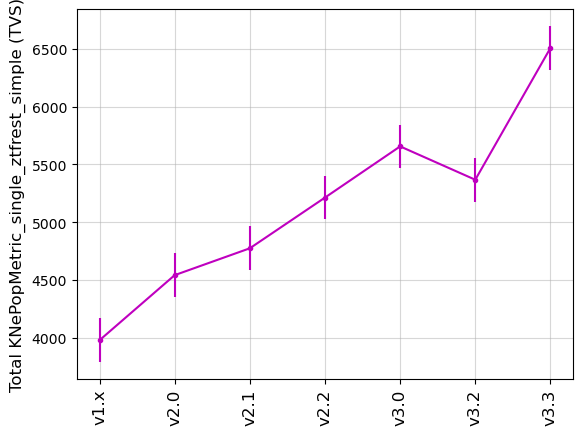

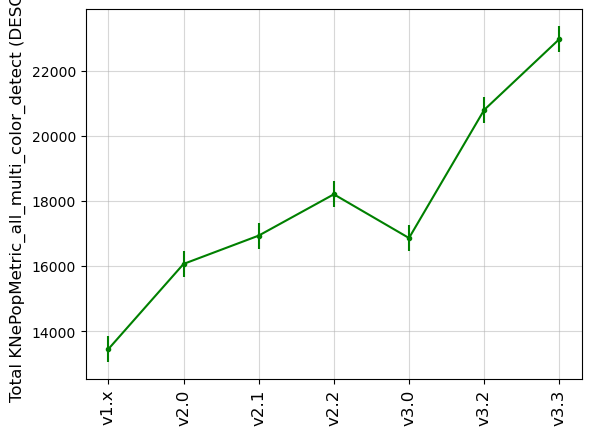

In [20]:
msub = metric_sets.loc['TVS KNe short']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    if m['invert']:
        ax.invert_yaxis()
    ax.grid(True, alpha=0.5)
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

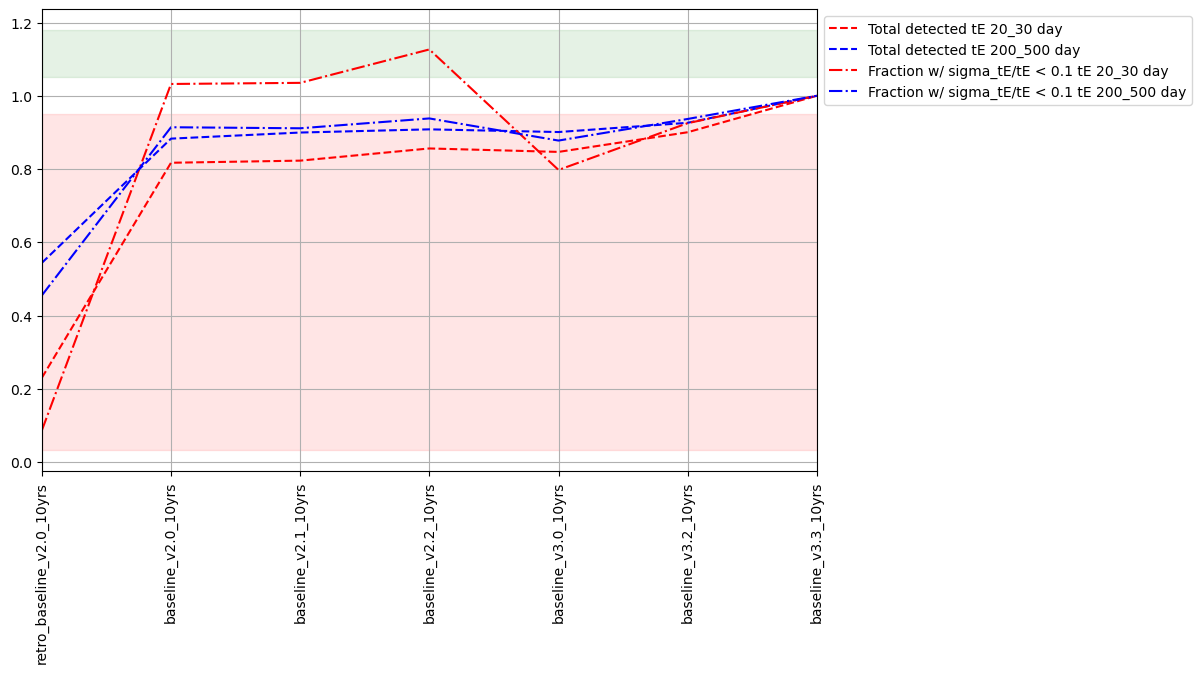

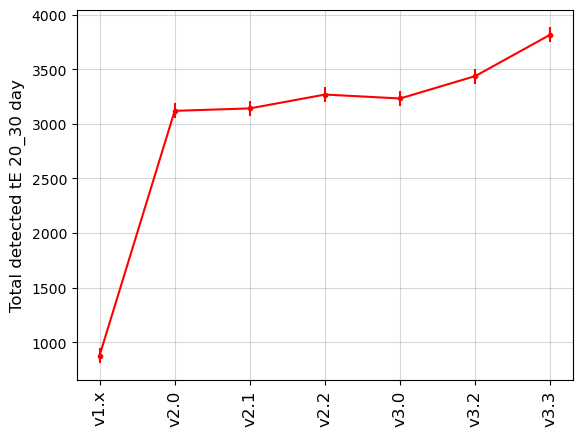

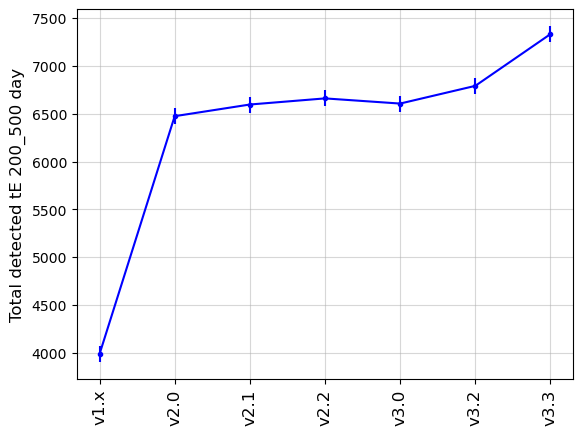

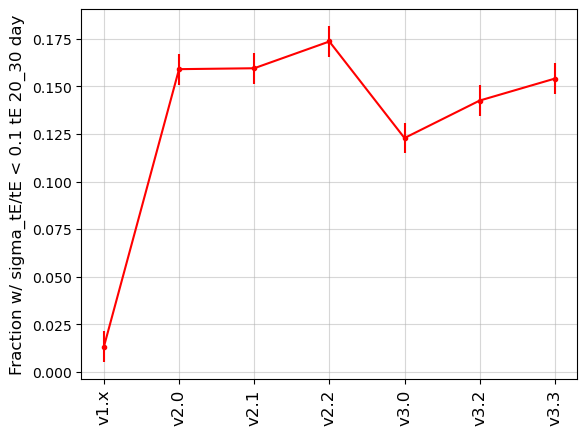

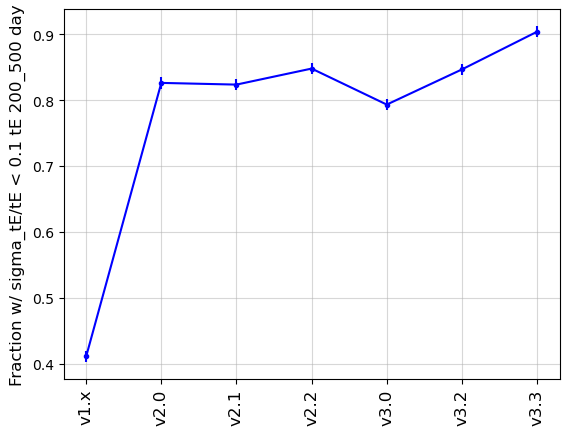

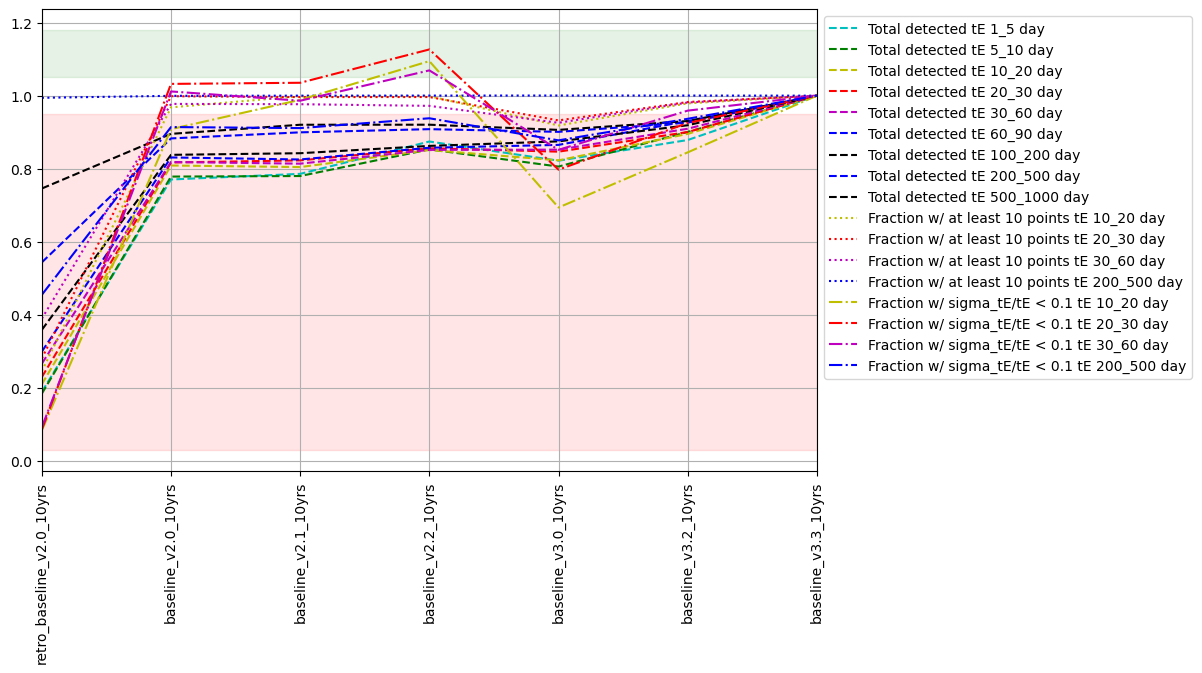

In [21]:
msub = metric_sets.loc['TVS microlensing short']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    if m['invert']:
        ax.invert_yaxis()
    ax.grid(True, alpha=0.5)
    #fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

msub = metric_sets.loc['TVS microlensing all']
fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

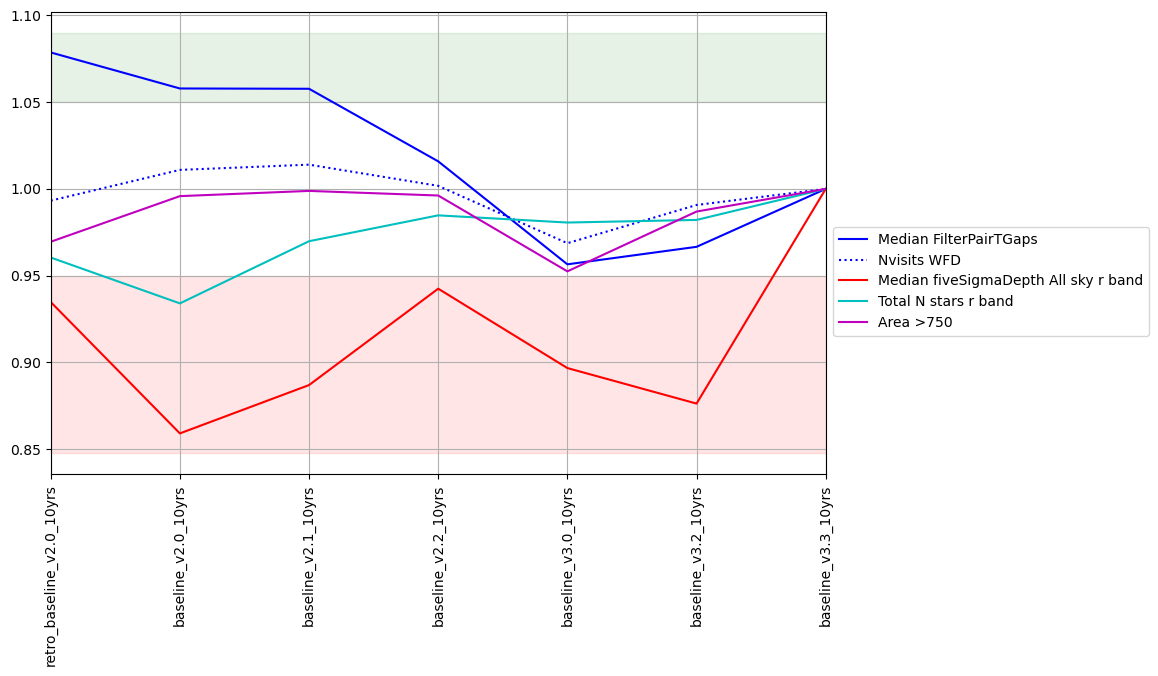

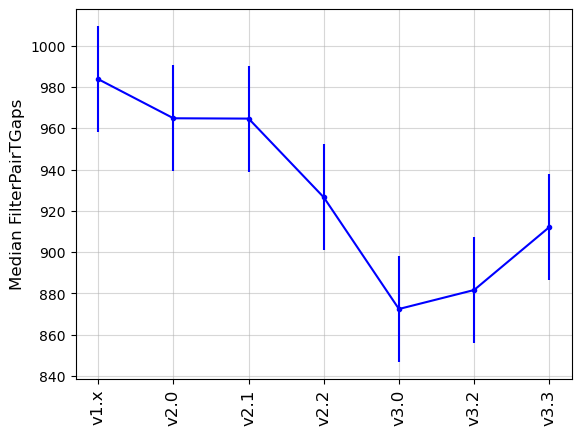

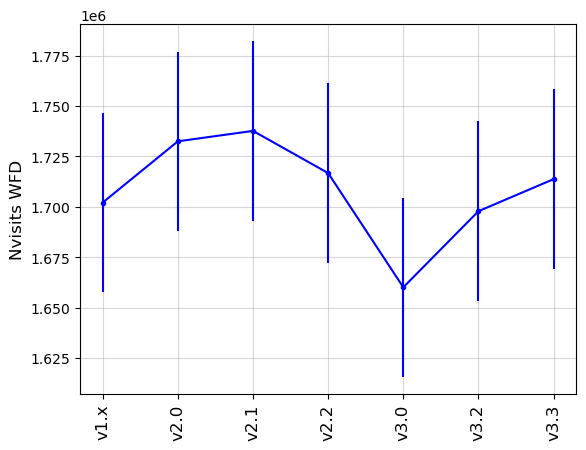

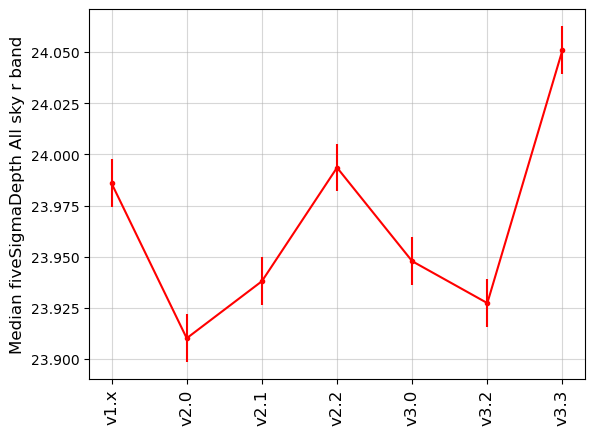

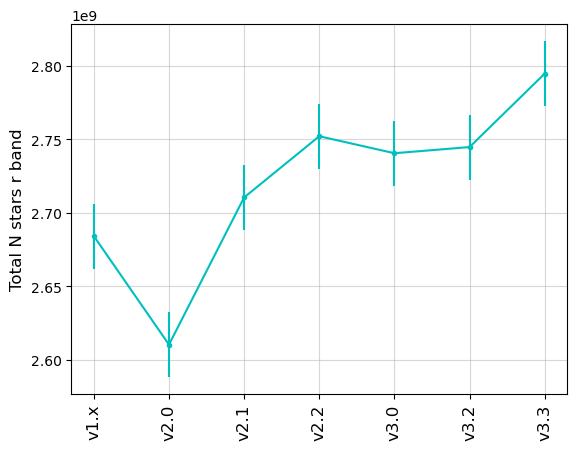

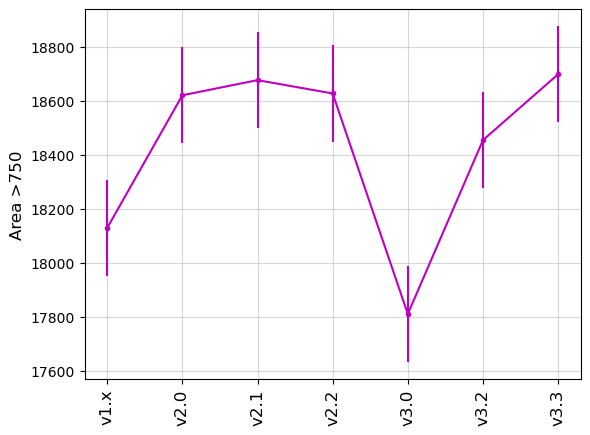

In [22]:
msub = metric_sets.loc['TVS anomalies']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')
ax.legend(loc=(1.01, 0.3))
              
for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    if m['invert']:
        ax.invert_yaxis()
    ax.grid(True, alpha=0.5)
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

### Solar System Objects
<a id="SSO"></a>
Metrics related to Solar System Science Collaboration goals. 

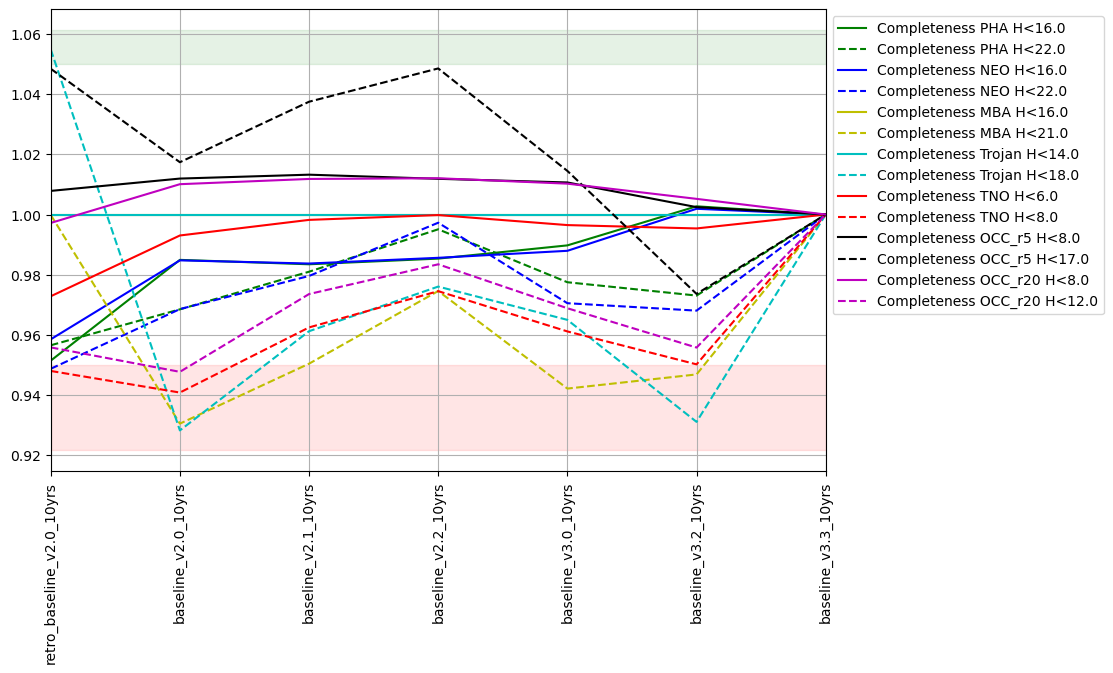

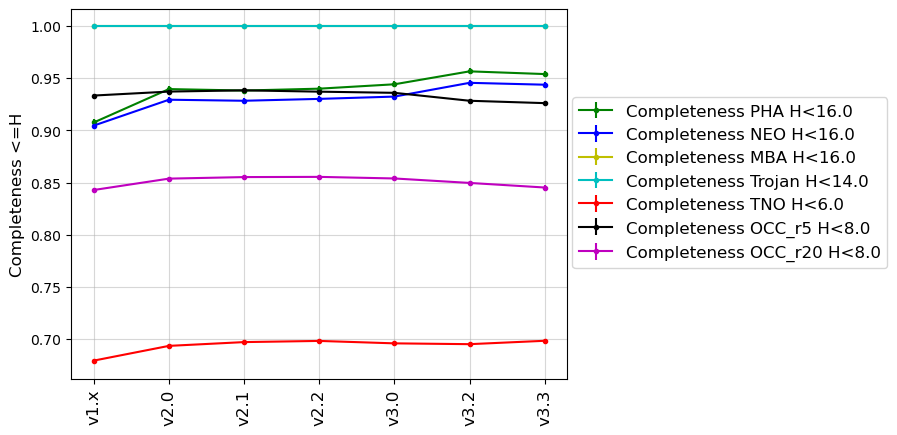

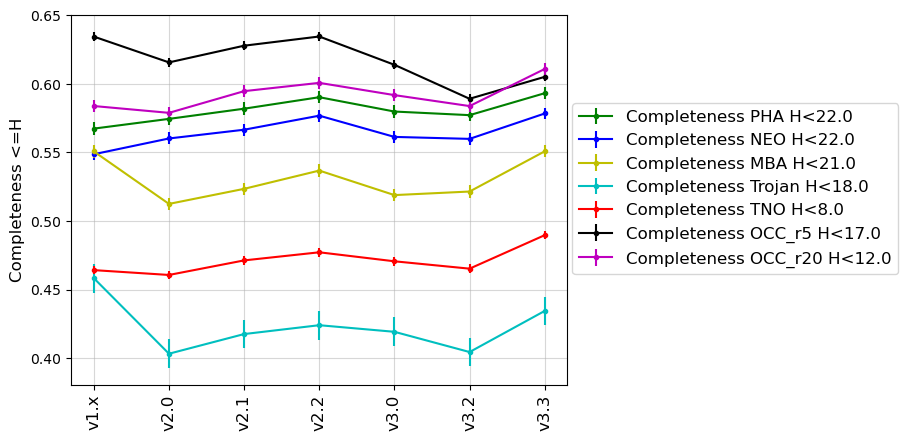

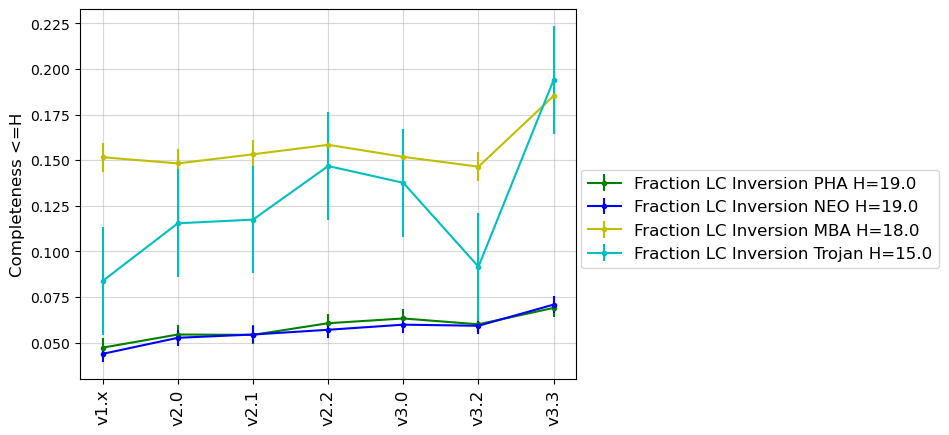

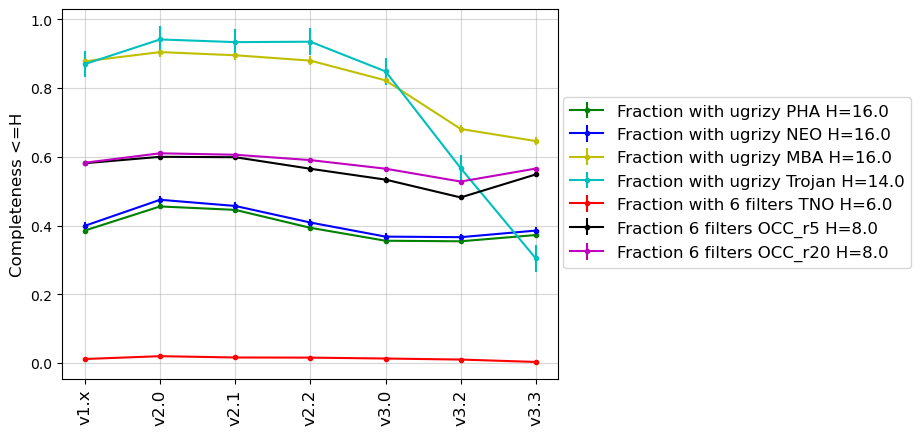

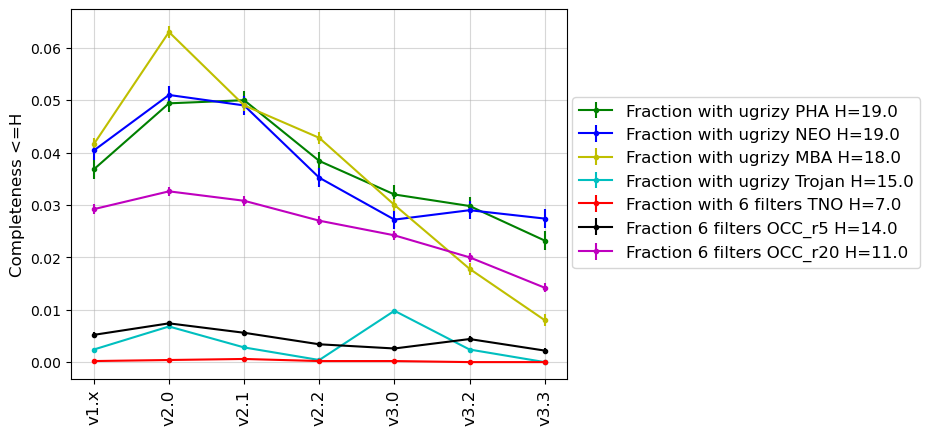

In [23]:
msub = metric_sets.loc['SSO discovery']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

msub = metric_sets.loc['SSO discovery'][::2]

fig, ax = plt.subplots() 
for i, m in msub.iterrows():
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
ax.legend(loc=(1.01, 0.3), fancybox=True, fontsize='large')
ax.set_ylabel('Completeness <=H', fontsize='large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
if m['invert']:
    ax.invert_yaxis()
ax.grid(True, alpha=0.5)
fig.savefig(os.path.join(outdir, 'completeness_bright' + '.png'), format='png')

msub = metric_sets.loc['SSO discovery'][1::2]

fig, ax = plt.subplots() 
for i, m in msub.iterrows():
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
ax.legend(loc=(1.01, 0.3), fancybox=True, fontsize='large')
ax.set_ylabel('Completeness <=H', fontsize='large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
if m['invert']:
    ax.invert_yaxis()
ax.grid(True, alpha=0.5)
fig.savefig(os.path.join(outdir, 'completeness_faint' + '.png'), format='png')

msub = metric_sets.loc['SSO lightcurve inversion'][1::2]
fig, ax = plt.subplots() 
for i, m in msub.iterrows():
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
ax.legend(loc=(1.01, 0.3), fancybox=True, fontsize='large')
ax.set_ylabel('Completeness <=H', fontsize='large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
if m['invert']:
    ax.invert_yaxis()
ax.grid(True, alpha=0.5)
fig.savefig(os.path.join(outdir, 'lightcurves_faint' + '.png'), format='png')

msub = metric_sets.loc['SSO fraction 6 bands'][::2]
fig, ax = plt.subplots() 
for i, m in msub.iterrows():
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
ax.legend(loc=(1.01, 0.3), fancybox=True, fontsize='large')
ax.set_ylabel('Completeness <=H', fontsize='large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
if m['invert']:
    ax.invert_yaxis()
ax.grid(True, alpha=0.5)
fig.savefig(os.path.join(outdir, 'colors6_bright' + '.png'), format='png')

msub = metric_sets.loc['SSO fraction 6 bands'][1::2]
fig, ax = plt.subplots() 
for i, m in msub.iterrows():
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
ax.legend(loc=(1.01, 0.3), fancybox=True, fontsize='large')
ax.set_ylabel('Completeness <=H', fontsize='large')
ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
if m['invert']:
    ax.invert_yaxis()
ax.grid(True, alpha=0.5)
fig.savefig(os.path.join(outdir, 'colors6_faint' + '.png'), format='png')

### AGN
<a id="AGN"></a>
Metrics contributed by the Active Galactic Nuclei science collaboration.

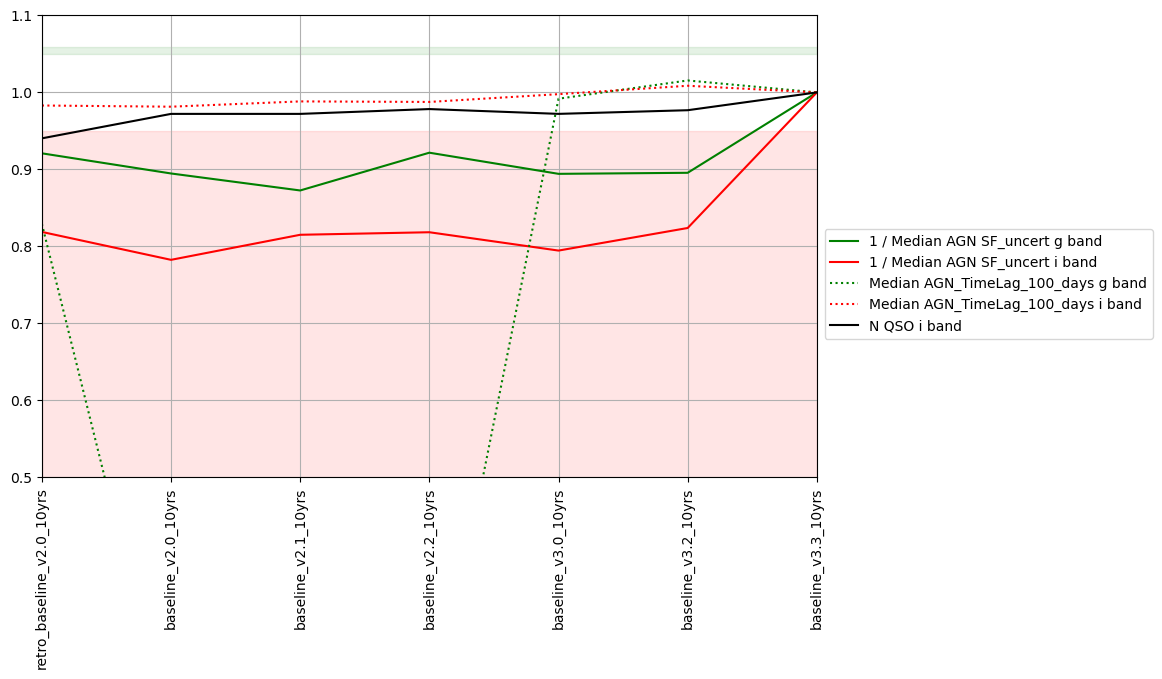

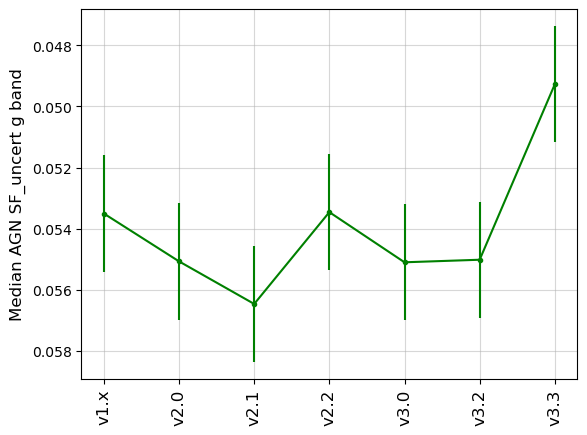

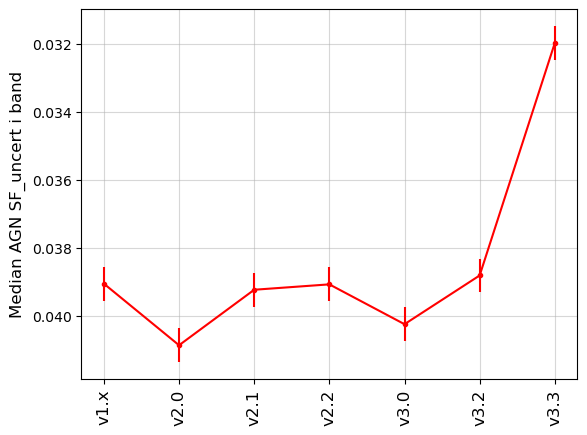

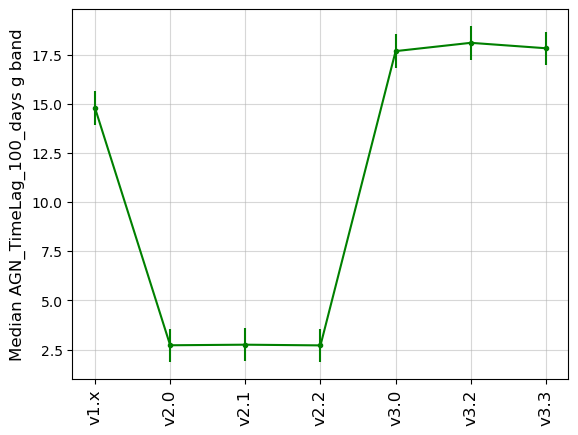

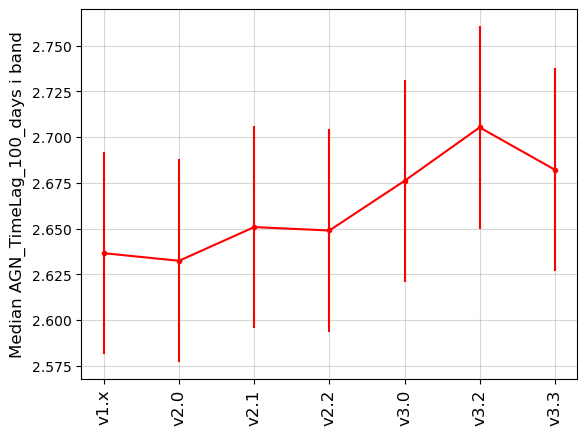

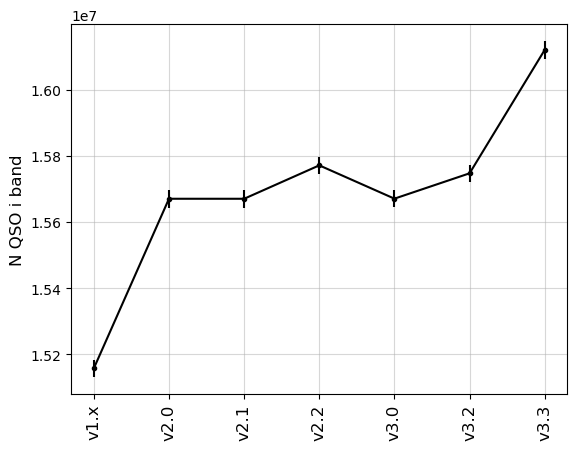

In [24]:
msub = metric_sets.loc['AGN short']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')
ax.legend(loc=(1.01, 0.3))
ax.set_ylim(0.5, 1.1)
              
for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    if m['invert']:
        ax.invert_yaxis()
    ax.grid(True, alpha=0.5)
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

### Galaxies
<a id="Galaxies"></a>
Metrics evaluating the total number of galaxies expected in the survey.

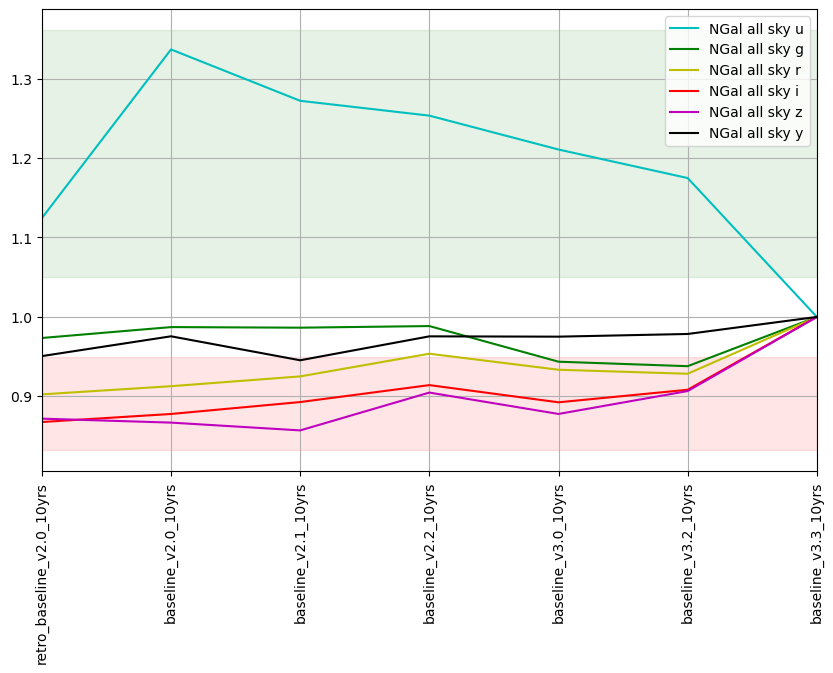

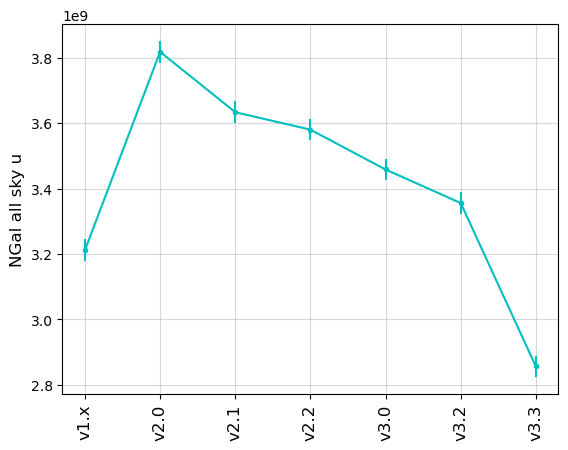

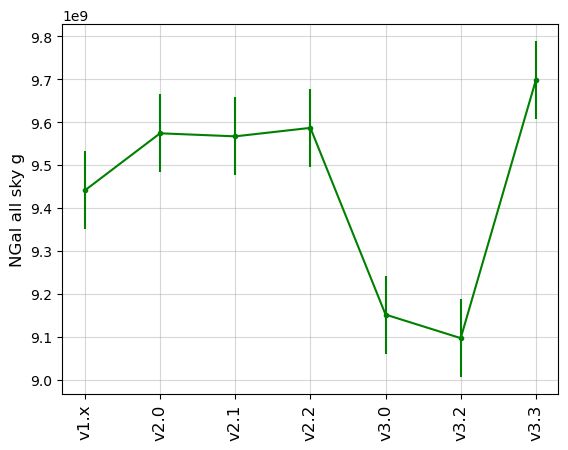

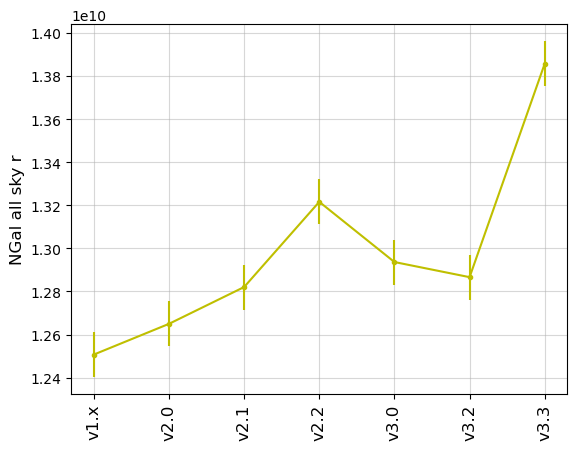

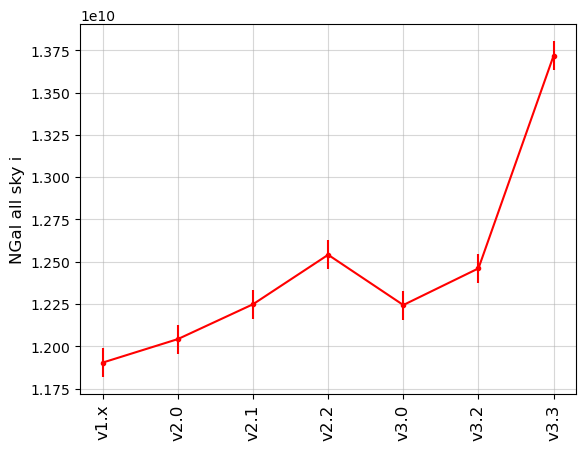

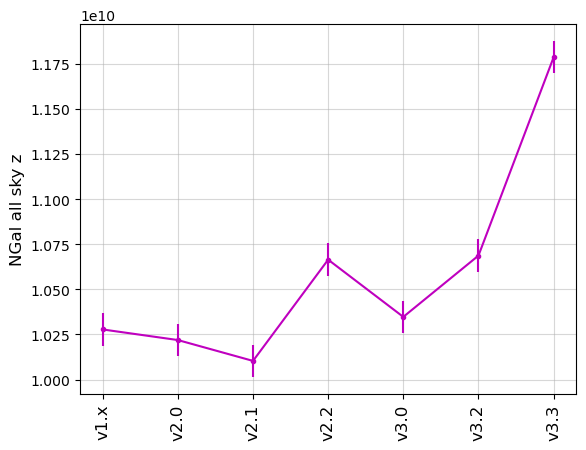

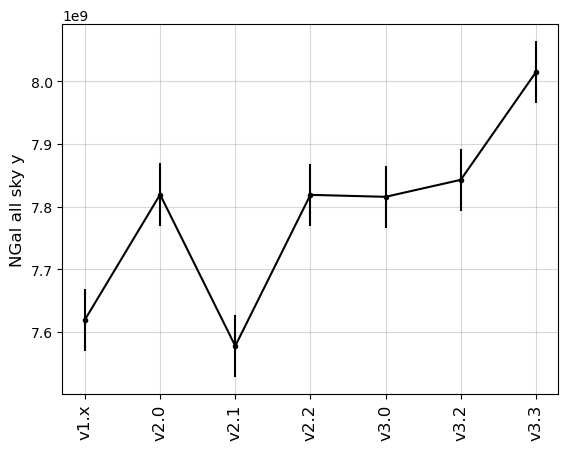

In [25]:
msub = metric_sets.loc['galaxies']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    if m['invert']:
        ax.invert_yaxis()
    ax.grid(True, alpha=0.5)
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

### Strong Lensing
<a id="StrongLensing"></a>
Metrics contributed by the Strong Lensing Science Collaboration. 

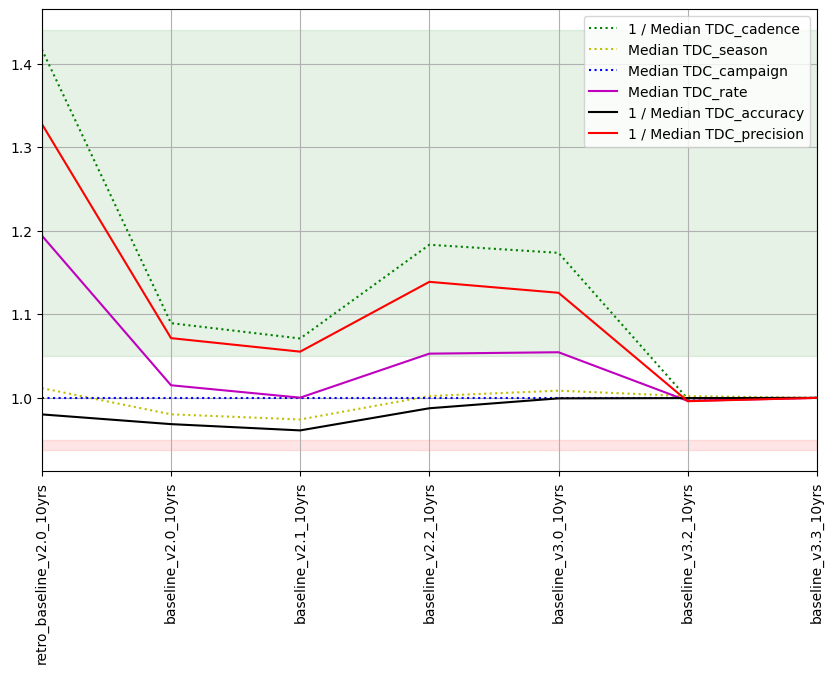

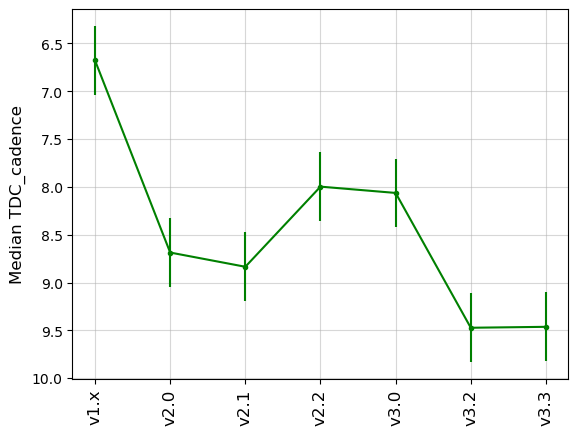

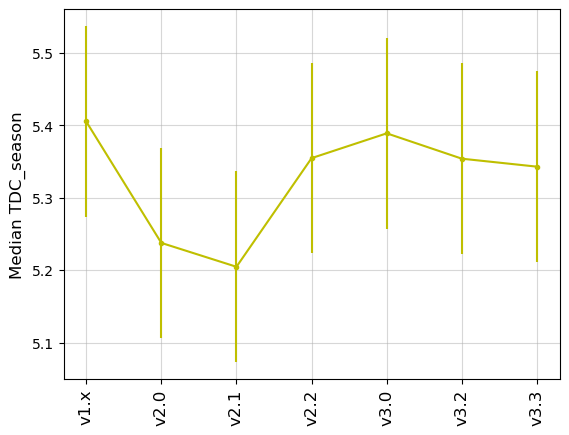

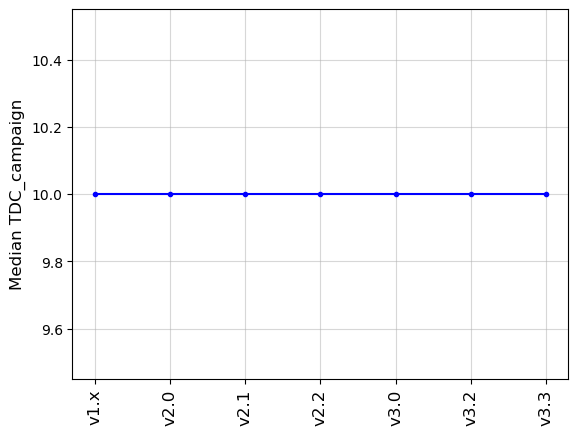

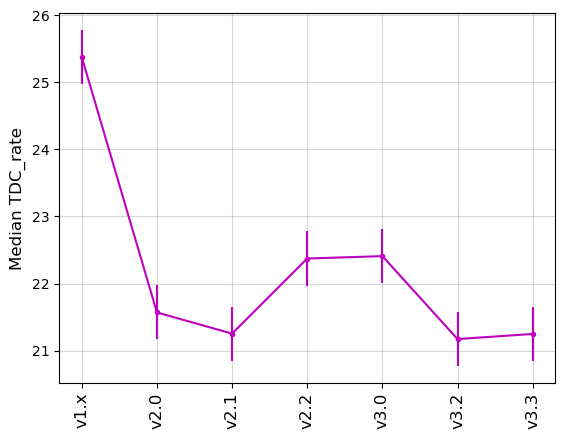

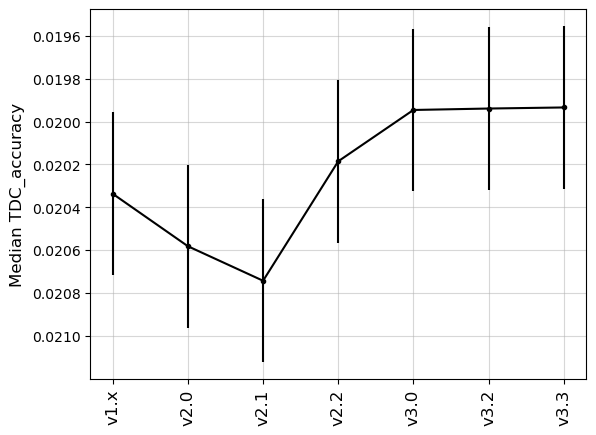

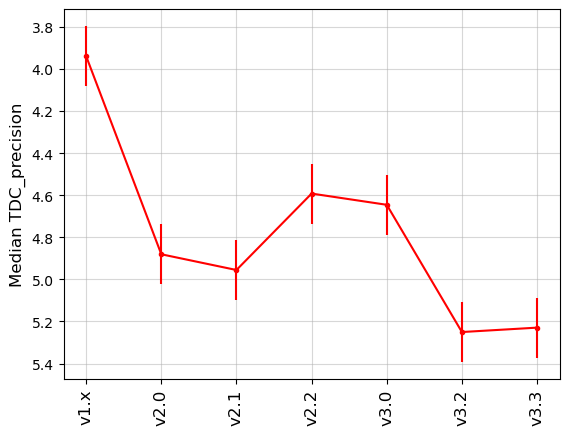

In [26]:
msub = metric_sets.loc['SL TDC']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    if m['invert']:
        ax.invert_yaxis()
    ax.grid(True, alpha=0.5)
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

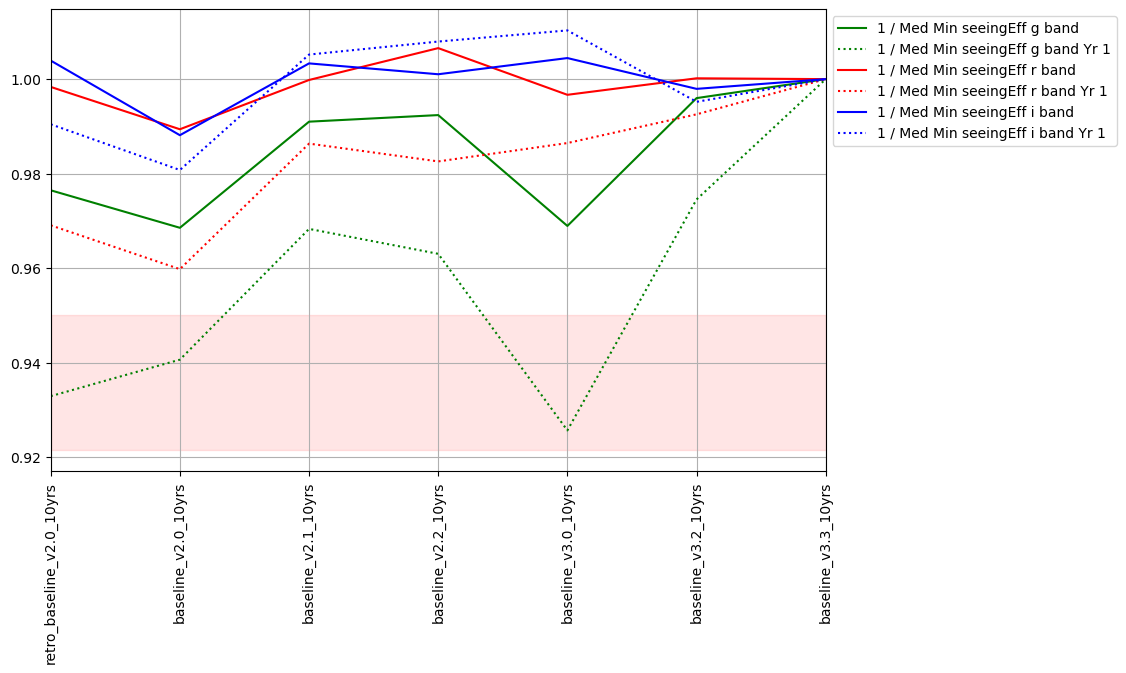

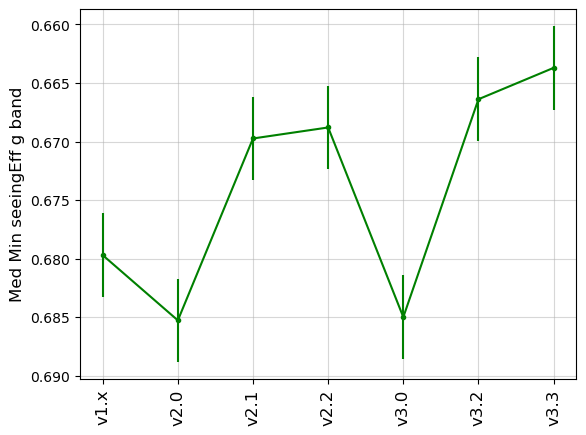

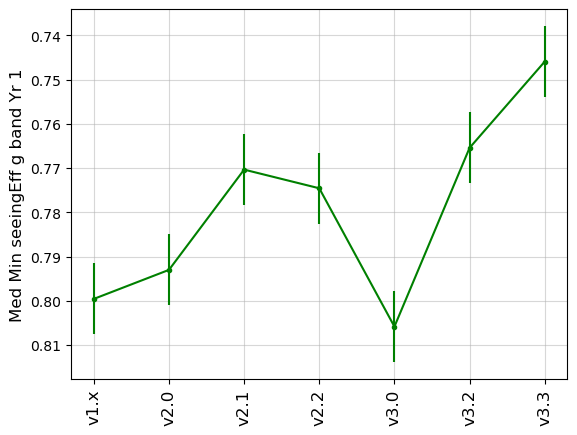

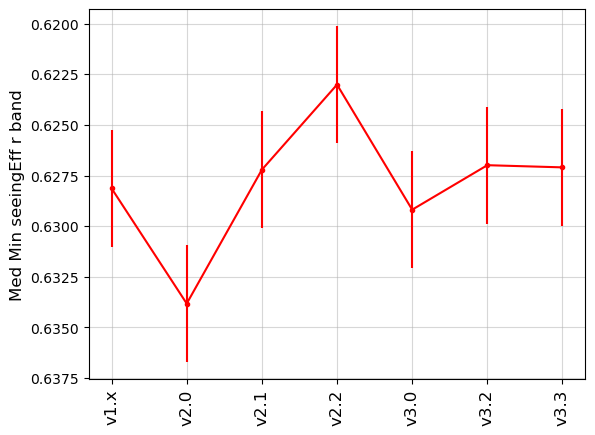

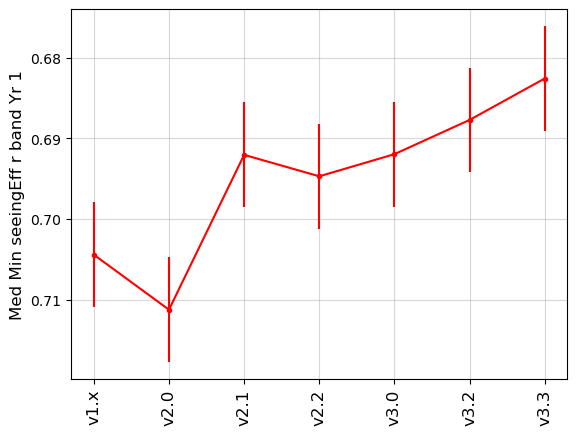

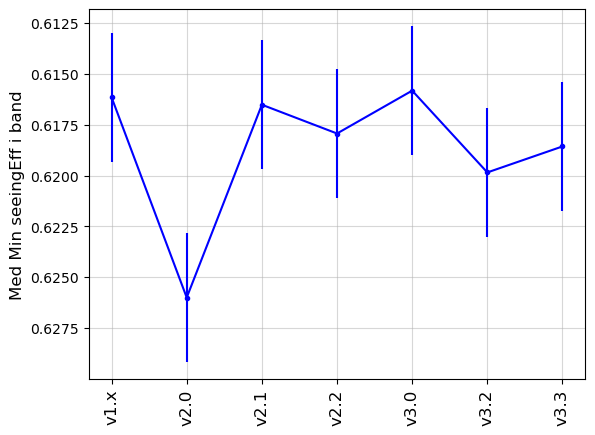

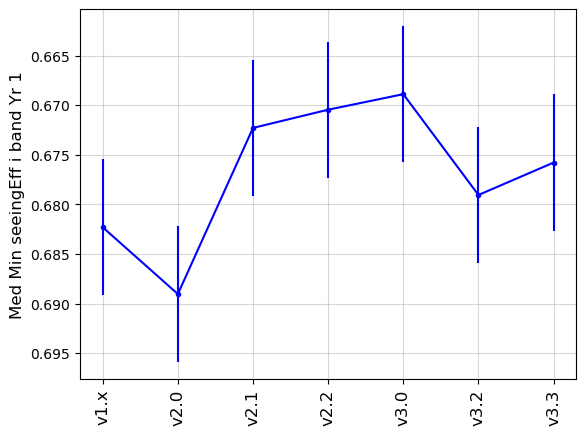

In [27]:
msub = metric_sets.loc['SL IQ']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    if m['invert']:
        ax.invert_yaxis()
    ax.grid(True, alpha=0.5)
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

### Stars
<a id="Stars"></a>
Metrics considering total number of stars available in the survey. 

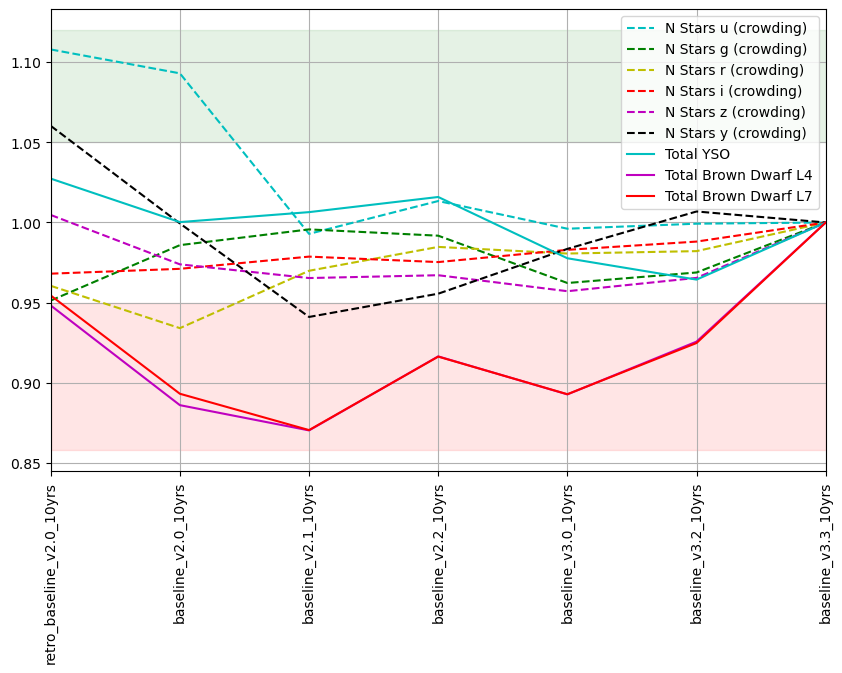

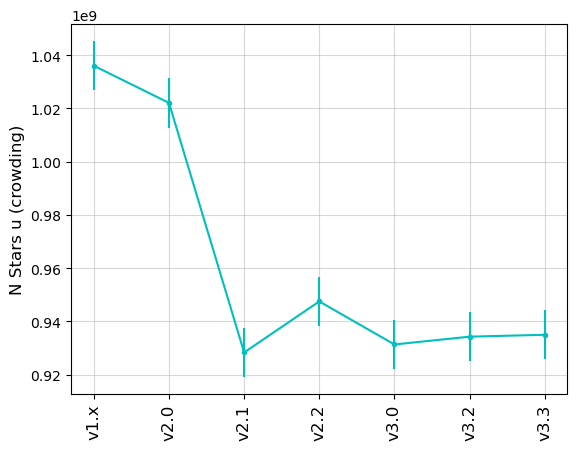

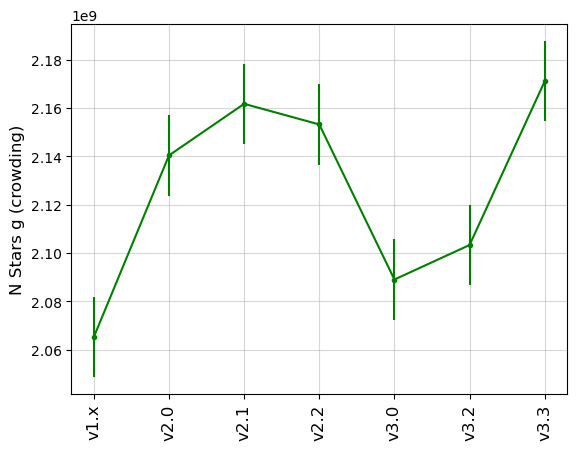

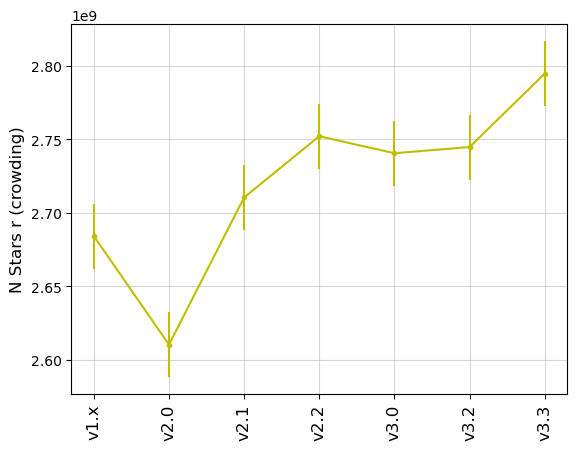

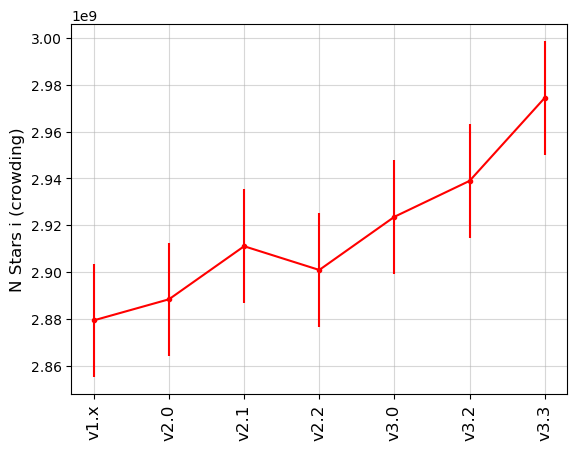

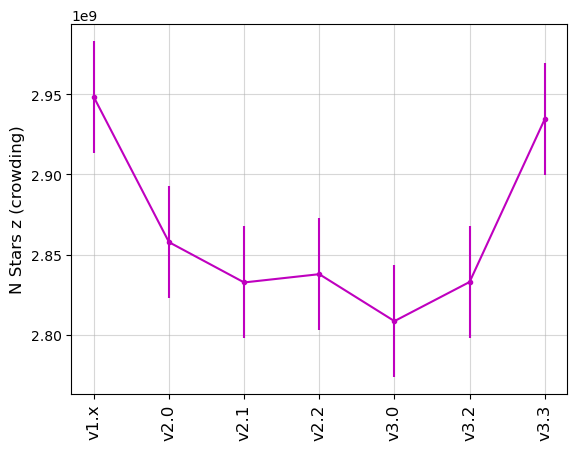

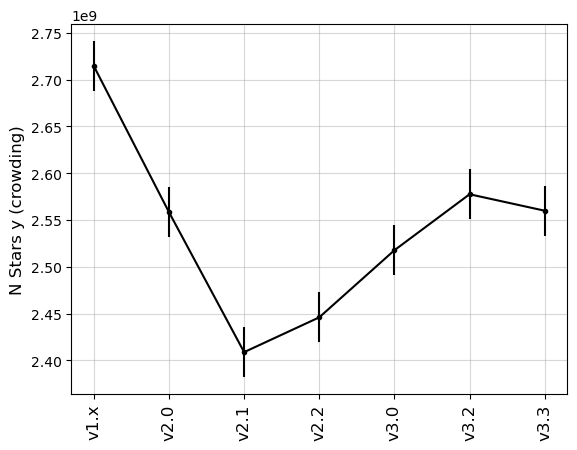

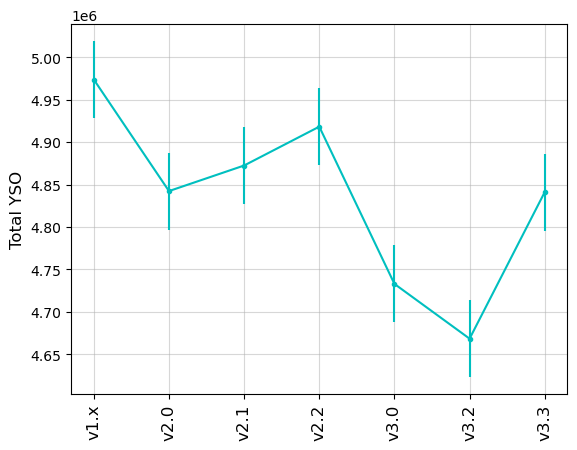

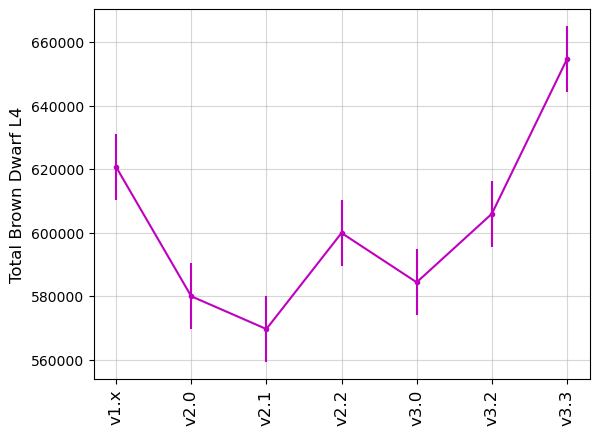

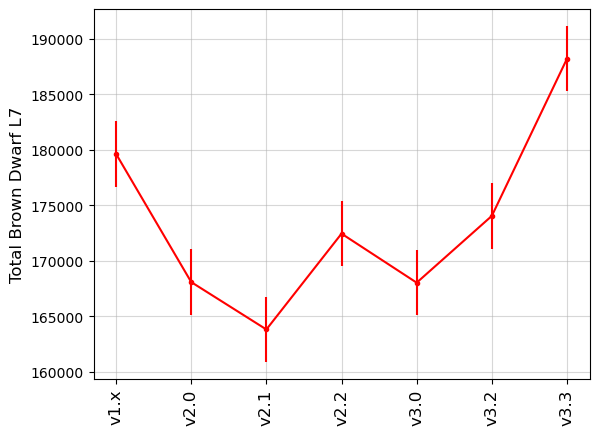

In [28]:
msub = metric_sets.loc['Stars']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    if m['invert']:
        ax.invert_yaxis()
    ax.grid(True, alpha=0.5)
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

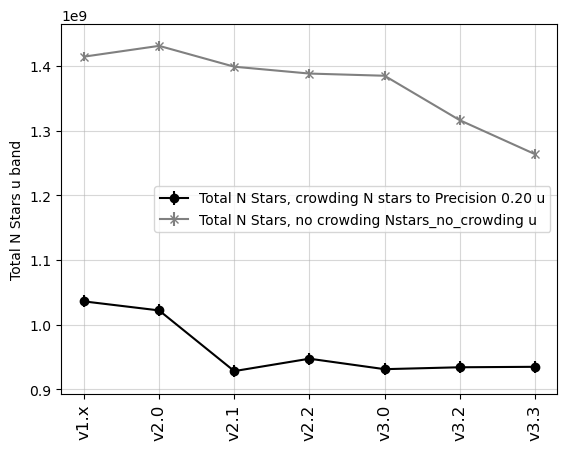

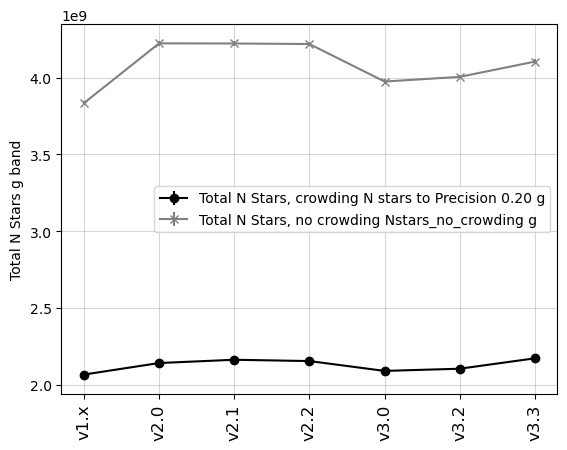

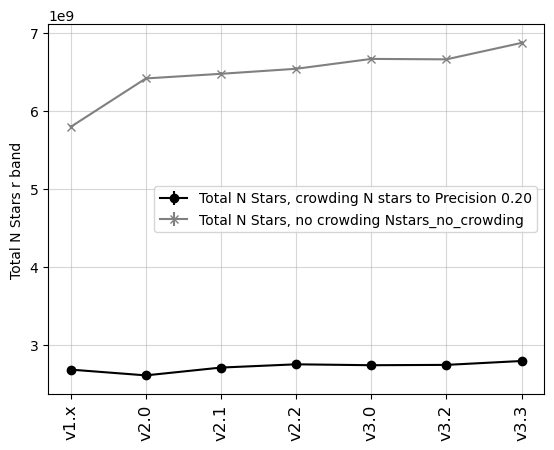

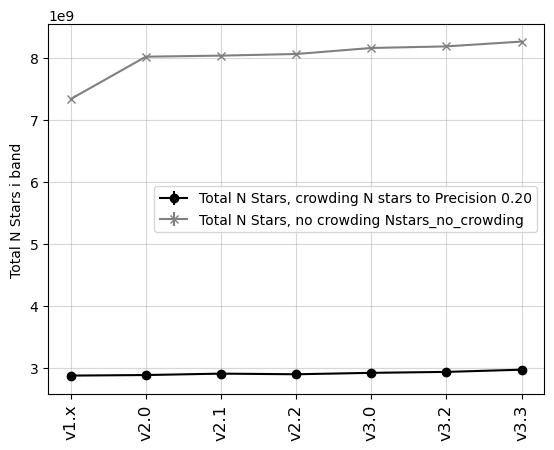

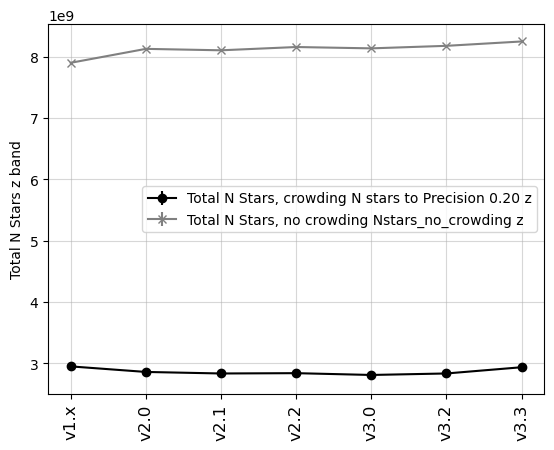

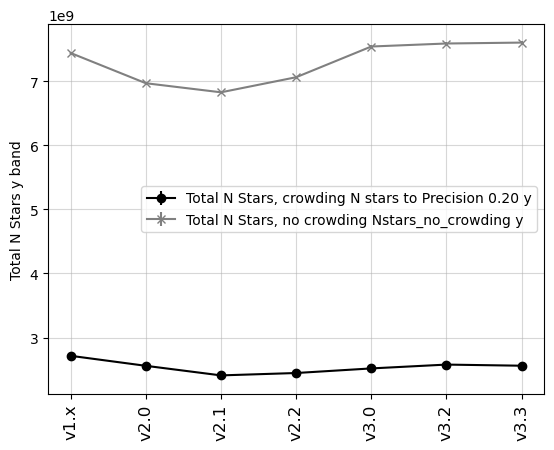

In [47]:
for f in 'ugrizy':
    metrics = [m for m in summaries if "Total N Stars" in m and f" {f} " in m]
    fig, ax = plt.subplots()
    for m, marker, color in zip(metrics, ['o', 'x'], ['black', 'gray']):
        ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m], yerr=dev[m], 
                    color=color, marker=marker, linestyle='-', label=m.rstrip(' HealpixSlicer'))
    ax.legend()
    ax.set_ylabel(f"Total N Stars {f} band")
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    ax.grid(True, alpha=0.5)

### Milky Way & Local Volume 
<a id="MWLV"></a>
Metrics for the local volume and milky way. These metrics tend to have a focus on galactic plane coverage, south celestial pole or SMC & LMC coverage. 


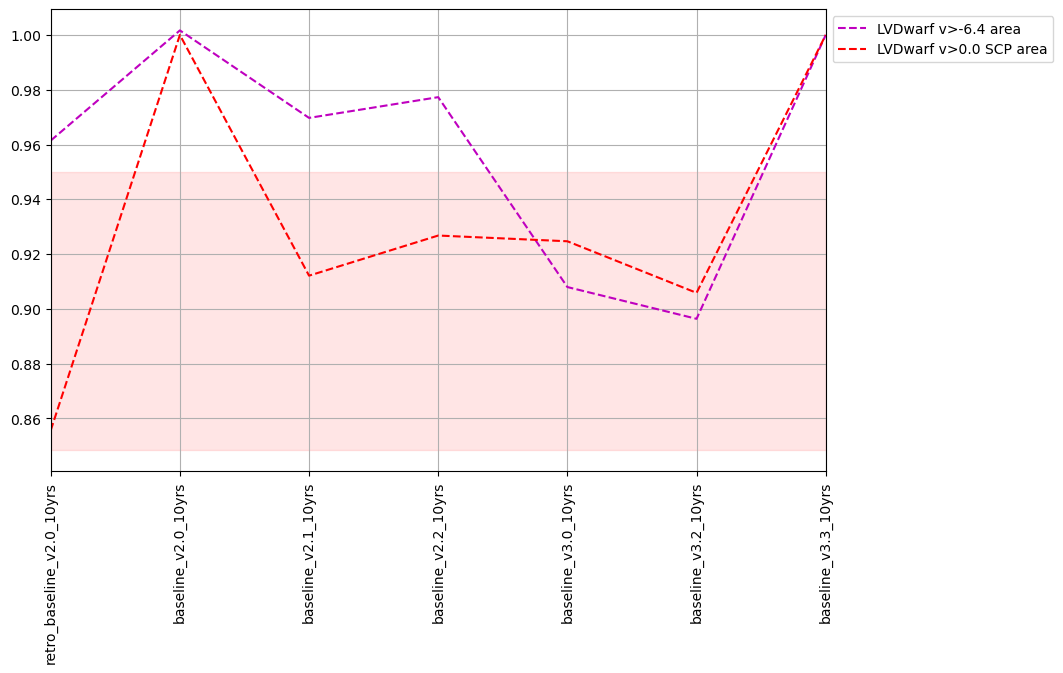

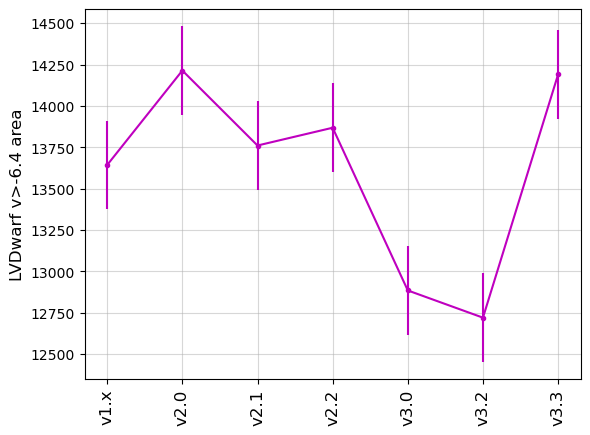

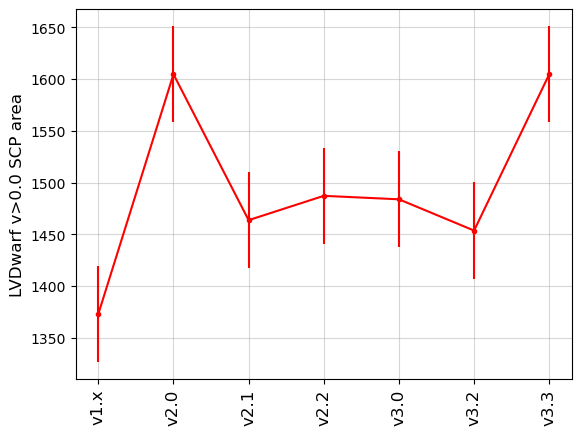

In [48]:
msub = metric_sets.loc['Local Volume']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    if m['invert']:
        ax.invert_yaxis()
    ax.grid(True, alpha=0.5)
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

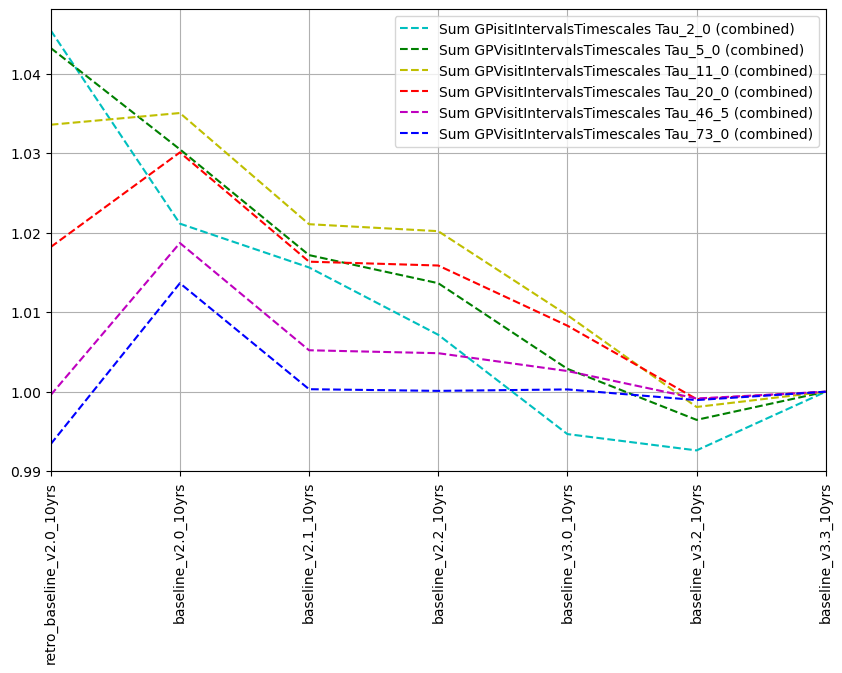

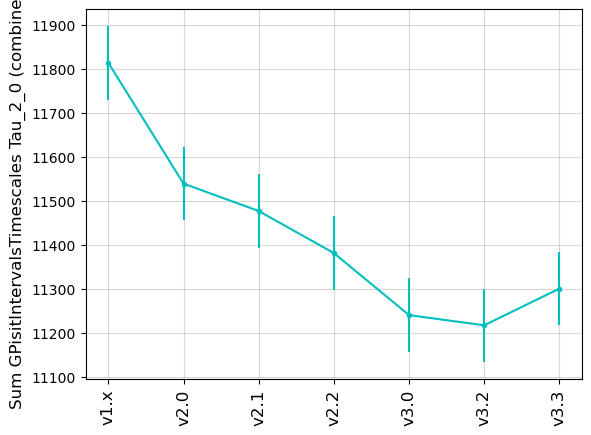

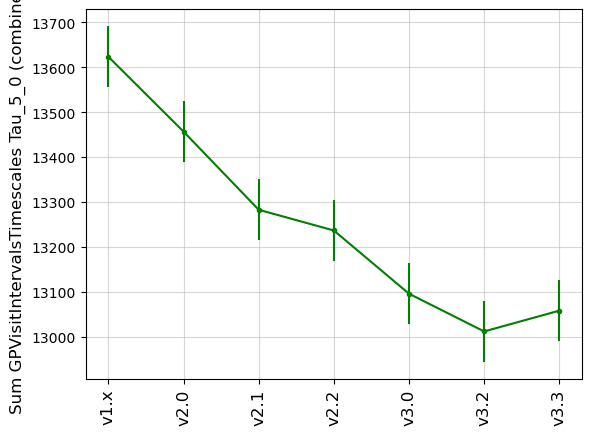

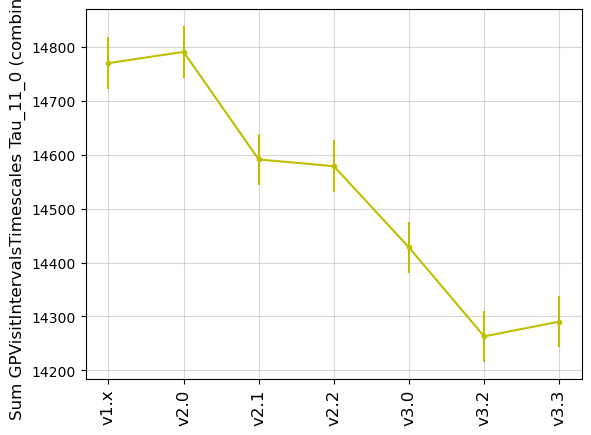

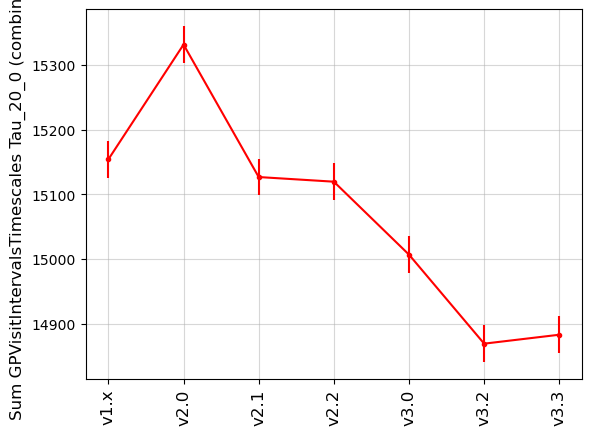

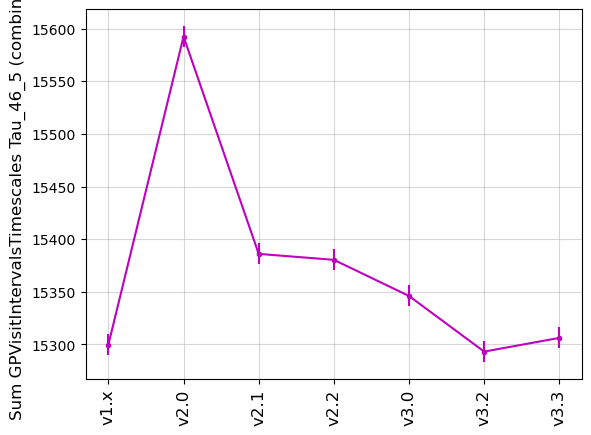

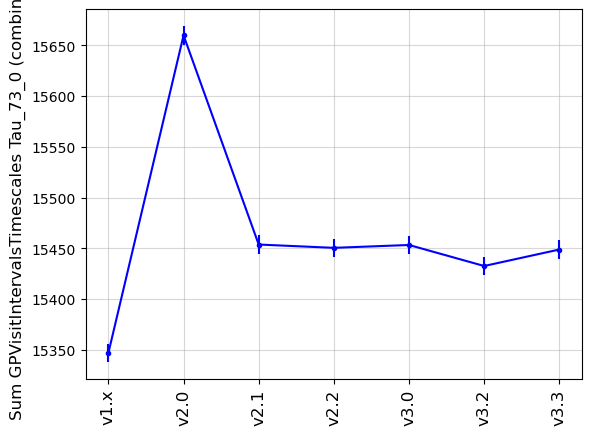

In [49]:
msub = metric_sets.loc['GP visit']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    if m['invert']:
        ax.invert_yaxis()
    ax.grid(True, alpha=0.5)
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')

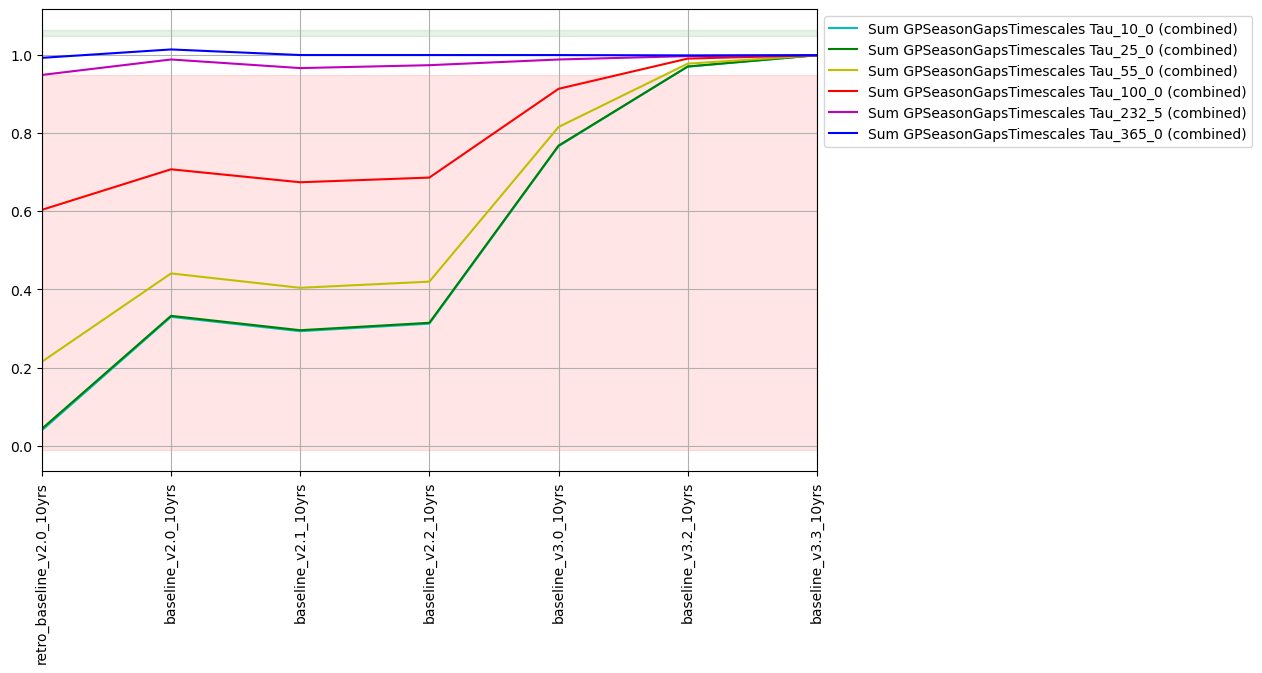

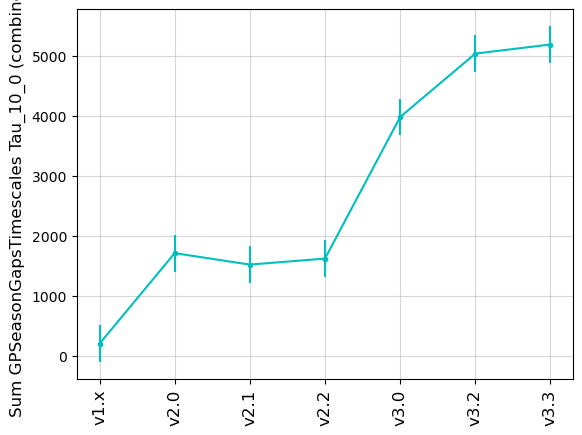

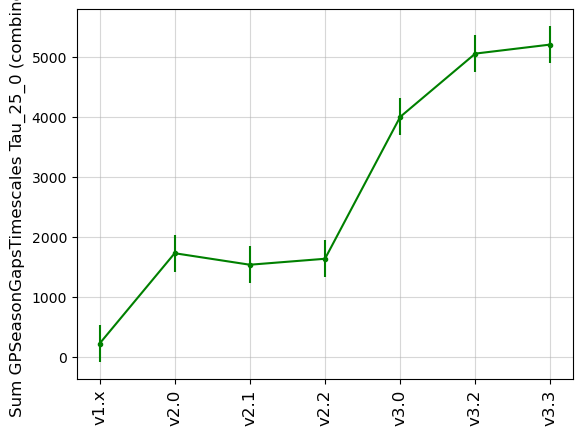

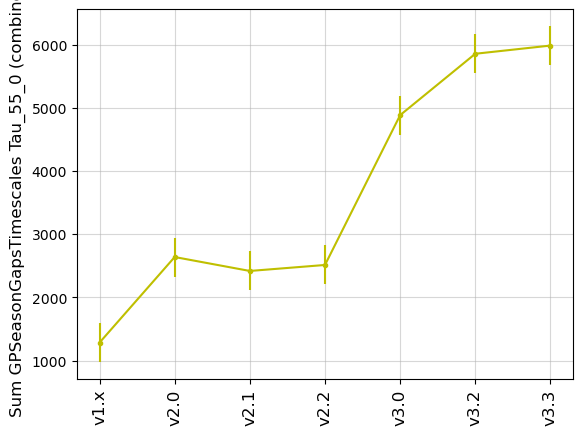

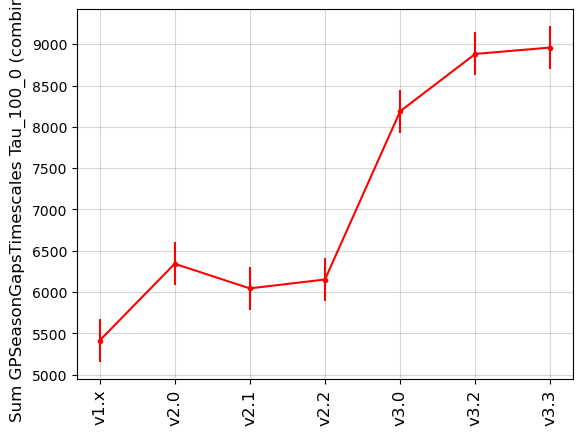

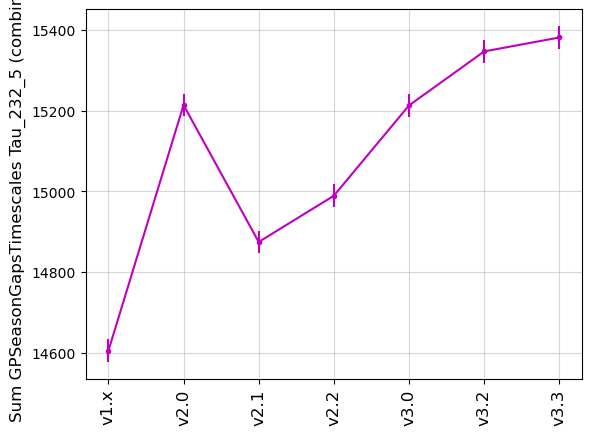

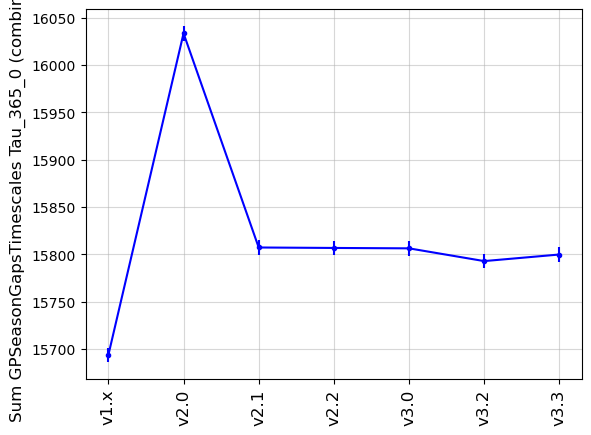

In [50]:
msub = metric_sets.loc['GP season']

fig, ax = maf.plot_run_metric(summaries.loc[baselines, msub['metric']], 
                              baseline_run=baseline_run, 
                              metric_set=msub,
                              metric_label_map=msub['short_name'],
                              horizontal_quantity='run',
                              vertical_quantity='value')

for i, m in msub.iterrows():
    fig, ax = plt.subplots() 
    ax.errorbar(list(baseline_dict.values()), summaries.loc[baselines, m['metric']], yerr=dev[m['metric']], 
                color=m['style'][0], marker='.', linestyle='-', label=m['short_name'])
    ax.set_ylabel(m['short_name'], fontsize='large')
    ax.tick_params(axis='x', labelrotation = 90, labelsize='large')
    if m['invert']:
        ax.invert_yaxis()
    ax.grid(True, alpha=0.5)
    fig.savefig(os.path.join(outdir, m['short_name'] + '.png'), format='png')